In [1]:
import os
import numpy as np

import imageio
import matplotlib
import matplotlib.pyplot as plt
#from scipy import signal
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import sys
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
import LL_funcs as LLf
from scipy.stats import norm
from tkinter import *
root = Tk()
root.withdraw()
import scipy
from scipy import signal
import pylab
import platform
from numpy import trapz
import tqdm
from matplotlib.patches import Rectangle
import freq_funcs as ff

subj            = "EL003"
cwd             = os.getcwd()
path_patient_analysis = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\'+subj

path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep =';'    
Fs = 500
#EEG_raw  = EEG_resp
#EEG_resp = ff.lp_filter(EEG_resp, 45, Fs)

In [2]:
def plot_raw_LL_IO(sc, rc, LL_all, LL_mean,EEG_resp,labels_all,  path_patient):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    conds    = np.unique(dat.Condition)
    w        = 0.25
    fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    axs[0] = fig.add_subplot(gs[0, 0])
    axs[1] = fig.add_subplot(gs[1, 0])

    axIO   = fig.add_subplot(gs[:, 1])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_CCEP        = 300
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    LL0              = np.min((LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc), 'LL norm']).values)
    mx_LL =1

    Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc), 'Int'])
    curve = np.zeros((3,len(Int_selc)))
    for i in range(len(Int_selc)):
        curve[0,i] = Int_selc[i]
        
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)]
        if len(dati)>0:
            resp             = ff.lp_filter(np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0),45,Fs)
            LL_resp,mx,max_ix, sig  = IOF.sig_resp(resp, chan_thr[rc,1])

            axs[0].plot( x_ax,resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
            axs[0].set_xlim(-0.2, 0.5)
            axs[1].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
            axs[1].plot(0.01+w/2+max_ix/Fs,mx, marker='+', c = [0,0,0], alpha=0.7+0.3*sig, markersize= 10)
            axs[1].set_xlim(-0.2, 0.5)
            #axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
            mx_norm = LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Int==Int_selc[i]), 'LL norm']
            curve[1,i] = mx_norm
            axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = color_elab[0], alpha=0.2+0.8*sig)
            limy_LL = np.nanmax([limy_LL, np.max(LL_resp)])
            limy_CCEP = np.nanmax([limy_CCEP, np.max(abs(resp[Fs:2*Fs]))])
            mx_LL = np.max([mx_LL, mx_norm.values[0]])
    #y = (data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'LL norm']*data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'Sig']).values
    curve[2,:]= LL0
    y = (LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc), 'LL norm']).values- LL0
    axIO.text(0,0.9, 'AUC: '+str(np.round(trapz(y, Int_selc)/np.max(Int_selc),2))) 
    #axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = color_elab[0], alpha=0.2+0.8*sig, label= color_elab[0]+', AUC (%): '+str(np.round(trapz(y, Int_selc)/12,2))) 
    axIO.fill_between(curve[0,:],curve[1,:], curve[2,:], color = color_elab[1], alpha=0.5)
    for i in range(2):
        axs[i].axvline(0, c=[0,0,0])   


    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.axhline(LL0, color="black", linestyle="--")

    axs[0].set_title('mean CCEP')
    axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')

    axs[0].set_ylabel('uV')
    axs[1].set_ylabel('uV/ms')
    axs[0].set_ylim(-limy_CCEP,limy_CCEP)
        #axs[2*i].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
    for i in range(len(conds)):
        #axs[2*i+1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
        axs[2*i+1].set_ylim(0,1.2*limy_LL)
    axs[2].set_xlabel('time [s]')

    plt.savefig(path_patient + '/Analysis/InputOutput/Ph/figures/'+subj+'_IO_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.savefig(path_patient + '/Analysis/InputOutput/Ph/figures/'+subj+'_IO_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.show()

In [3]:
stimlist = pd.read_csv(path_patient_analysis + '/InputOutput/Ph/data/stimlist_Ph.csv')

In [4]:
##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

lbls            = pd.read_excel(path_infos + "\\"+subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all      = lbls.label.values
labels_clinic   = lbls.Clinic.values
labels_region   = lbls.Region.values
labels_L        = lbls.Hemisphere.values
nodes           = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
bad_stims =np.where(labels_region=='OUT')[0]
#if subj == 'EL006':
 #     labels_all      = lbls.Clinic.values
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((4,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])
color_elab[3,:] = np.array([1, 0.574, 0])
conds = np.unique(stimlist.condition)
# get stimulation channels directly from stimlist
StimChanSM   = np.unique(stimlist.ChanP)
ChanN        = np.zeros((len(StimChanSM),))
StimChans    = []#np.zeros((len(stim_chan)))
StimChansC   = []#np.zeros((len(stim_chan)))
StimChanIx   = []#np.zeros((len(stim_chan)))
for i in range(len(StimChanSM)):
    ChanN[i] =  np.median(stimlist[stimlist.ChanP==StimChanSM[i]].ChanN)
    #StimChans.append(labels_SM[(np.array(labels.chan_num.values)==stim_chan[i,0])][0])
    StimChans.append(labels_all[(np.array(lbls.ChanP_SM.values)==StimChanSM[i])&(np.array(lbls.ChanN_SM.values)==ChanN[i])][0])
    StimChansC.append(labels_clinic[(np.array(lbls.ChanP_SM.values)==StimChanSM[i])&(np.array(lbls.ChanN_SM.values)==ChanN[i])][0])
    StimChanIx.append(lbls[(np.array(lbls.ChanP_SM.values)==StimChanSM[i])&(np.array(lbls.ChanN_SM.values)==ChanN[i])]['Num'].values[0]-1)
    # bad channels

In [6]:
Condition = 'Ph'
file = path_patient_analysis + '/InputOutput/'+Condition+'/data/con_trial.csv'
if os.path.isfile(file):
    con_trial    = pd.read_csv(file)
else:
    asdfasdf
    con_trial = get_LL_all_cond(EEG_resp, stimlist,bad_chans, path_patient, cond_sel = 'condition', w=0.25)

# file = path_patient + '/Analysis/InputOutput/LL/data/chan_sig_thr.csv'
# if os.path.isfile(file):
#     chan_thr    = pd.read_csv(file).values
# else:
#     chan_thr   = IOF.get_LL_thr(EEG_resp, LL_CCEP, labels_all, path_patient)
#     
# file = path_patient + '/Analysis/InputOutput/LL/data/sig_intensity_'+Condition+'.csv'
# if os.path.isfile(file):
#     LL_mean    = pd.read_csv(file)
# else:
#     LL_mean     = IOF.get_LL_mean(EEG_resp, LL_CCEP, chan_thr, labels_all, labels_region, 'Condition', path_patient,Fs=500)
#     
#     #IO_summary = IOF.get_IO_summary(LL_mean, 'Condition',labels_all,labels_region,path_patient )
# file = path_patient + '/Analysis/InputOutput/LL/data/IO_mean_'+Condition+'.csv'
# if os.path.isfile(file):
#     IO_summary    = pd.read_csv(file)
# else:
#     IO_summary    = IOF.get_IO_summary(LL_mean, Condition, labels_all, labels_region, path_patient)
#         

In [7]:
get_auc_all = 0
if get_auc_all:
    AUC_all = np.zeros((1,4))
    for sc in np.unique(con_trial.Stim).astype('int'):
        for rc in np.unique(con_trial.Chan).astype('int'):
            dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
            Int_all = np.unique(dat.Int)
            LL = dat.groupby(['Int'])['LL'].mean() # /LL_max

            if np.max(LL)/np.min(LL)>3:

                LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
                dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
                LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())

                AUC1 = np.trapz(np.repeat(LL_max, len(Int_all)) - LL_min, Int_all)

                for cond in [1,3]:
                    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&~np.isnan(con_trial.LL)]
                    if len(dat)>0:
                        LL = dat.groupby(['Int'])['LL'].mean() # /LL_max
                        AUC = np.trapz(LL - LL_min, np.unique(dat.Int.values))/ AUC1 #sklearn.metrics.auc(np.unique(dat.Int), LL-LL_min/LL_max)

                        auc_sing = [[sc,rc,AUC,cond]]
                        AUC_all = np.concatenate([AUC_all, auc_sing])
    AUC_all = AUC_all[1:,:]
    AUC_all = pd.DataFrame(AUC_all, columns=['Stim','Chan','AUC','Condition'])

    AUC_all.insert(0,'Resp_Area','hipp')
    AUC_all.insert(0,'Stim_Area','hipp')
    for sc in np.unique(AUC_all[['Stim', 'Chan']]).astype('int'):
        AUC_all.loc[AUC_all.Stim==sc,'Stim_Area'] =lbls.Area.values[sc]
        AUC_all.loc[AUC_all.Chan==sc,'Resp_Area'] =lbls.Area.values[sc]
    AUC_all = AUC_all[AUC_all.AUC>0]
    AUC_all.to_csv('Y:\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\'+subj+'_AUC_all.csv', header=True, index=False)

In [8]:
## load all
if os.path.isfile(path_patient_analysis + '/InputOutput/Ph/data/EEG_Ph.npy'):
    EEG_resp = np.load(path_patient_analysis + '//InputOutput/Ph/data/EEG_Ph.npy')
    stimlist = pd.read_csv(path_patient_analysis + '/InputOutput/Ph/data/stimlist_Ph.csv')
else:
    EEG_resp = np.load(path_patient_analysis + '/InputOutput/data/All_resps.npy')
    stimlist = pd.read_csv(path_patient_analysis + '/InputOutput/data/Stimlist.csv')


print('data loaded with '+str(EEG_resp.shape[1])+' stimulations')
badchans = pd.read_csv(path_patient_analysis + '/InputOutput/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])
if len(stimlist)!= EEG_resp.shape[1]:
    print("WARNING: number of stimulations don't agree!")

data loaded with 288 stimulations


In [ ]:
stop

## FIG 1

single connection IO wihtout GABA modulation

In [26]:
Int_all = np.unique(con_trial.Int)
color_int      = np.zeros((len(Int_all),3))
color_int[:,0] = np.linspace(0, 1, len(Int_all))

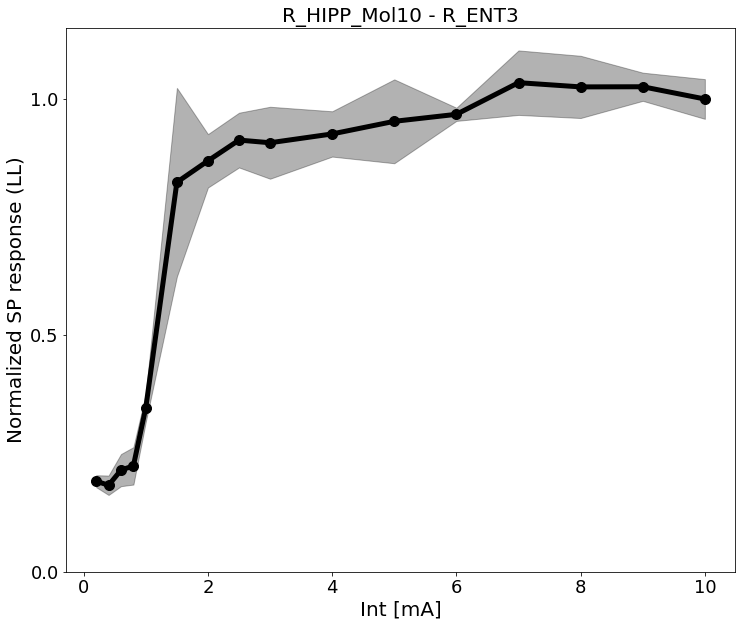

In [108]:
sc = 9
rc = 2
plt.figure(figsize=(12,10))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())
    
for cond in [1]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)]
    LL = dat.groupby(['Int'])['LL'].mean()
    LLstd = dat.groupby(['Int'])['LL'].std()
    #LLstd[1.5] = LLstd[1.5]/2 
    plt.plot(np.unique(dat.Int), LL/LL_max, color=[0,0,0], linewidth=5, marker='o', markersize=10)
    plt.fill_between(np.unique(dat.Int), (LL-LLstd)/LL_max,(LL+LLstd)/LL_max, color=[0,0,0], alpha=0.3)
#plt.axhspan(0, 1)
plt.xticks(fontsize=18)
plt.ylabel('Normalized SP response (LL)', fontsize=20)
plt.xlabel('Int [mA]', fontsize=20)
plt.yticks([0,0.5,1], fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\FIG1\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\FIG1\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')


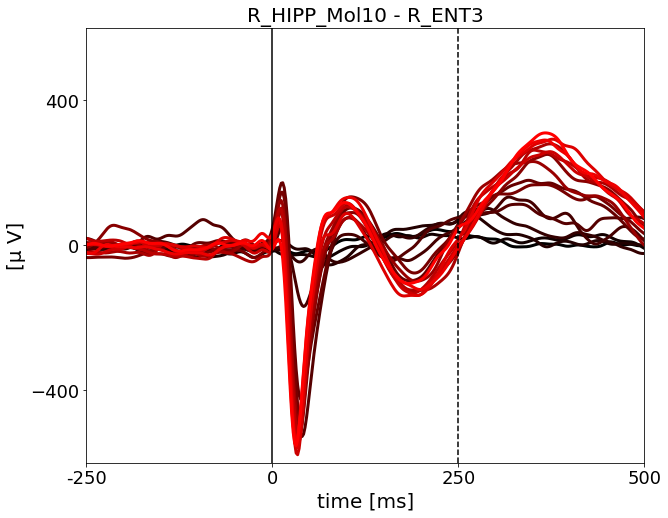

In [109]:
plt.figure(figsize=(10,8))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)
for Int,i in zip(Int_all, np.arange(len(Int_all))):
    for cond in [1]:
        dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&(con_trial.Int==Int)]
        StimNum = dat.Num.values.astype('int')
        mn = np.mean(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
        st = np.std(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
        plt.plot(x_ax, mn, color=color_int[i], linewidth=3)
        # plt.fill_between(x_ax, mn-st, mn+st, color=cond_colors[cond], alpha =0.1)
plt.xlim([-0.25,0.5])
plt.ylim([-600,600])
plt.axvline(0, color= [0,0,0])
plt.axvline(0.25, color= [0,0,0], linestyle= '--')
plt.xticks([-0.25,0.,0.25,0.5], ['-250', '0', '250', '500'], fontsize=18)
plt.yticks([-400,0,400], fontsize=18)
plt.ylabel('[\u03BC V]', fontsize=20)
plt.xlabel('time [ms]', fontsize=20)
plt.yticks(fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\FIG1\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_ccep.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\FIG1\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_ccep.jpg')
plt.show()

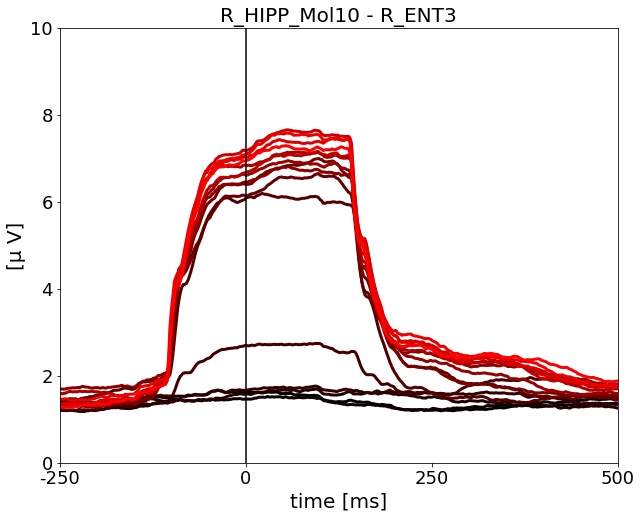

In [111]:
plt.figure(figsize=(10,8))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)
for Int,i in zip(Int_all, np.arange(len(Int_all))):
    for cond in [1]:
        dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&(con_trial.Int==Int)]
        StimNum = dat.Num.values.astype('int')
        LL = LLf.get_LL_all(EEG_resp[[[rc]], StimNum,:], Fs= Fs, win=0.25, t0=0, IPI=0)
        mn = np.mean(LL[0, :,:],0)
        st = np.std(LL[0, :,:],0)
        plt.plot(x_ax, mn, color=color_int[i], linewidth=3)
        # plt.fill_between(x_ax, mn-st, mn+st, color=cond_colors[cond], alpha =0.1)
plt.xlim([-0.25,0.5])
plt.ylim([0,10])
plt.axvline(0, color= [0,0,0])
plt.xticks([-0.25,0.,0.25,0.5], ['-250', '0', '250', '500'], fontsize=18)
#plt.yticks([-400,0,400], fontsize=18)
plt.ylabel('[\u03BC V]', fontsize=20)
plt.xlabel('time [ms]', fontsize=20)
plt.yticks(fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\FIG1\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_LL.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\FIG1\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_LL.jpg')
plt.show()

## FIG 2, GABA modulation

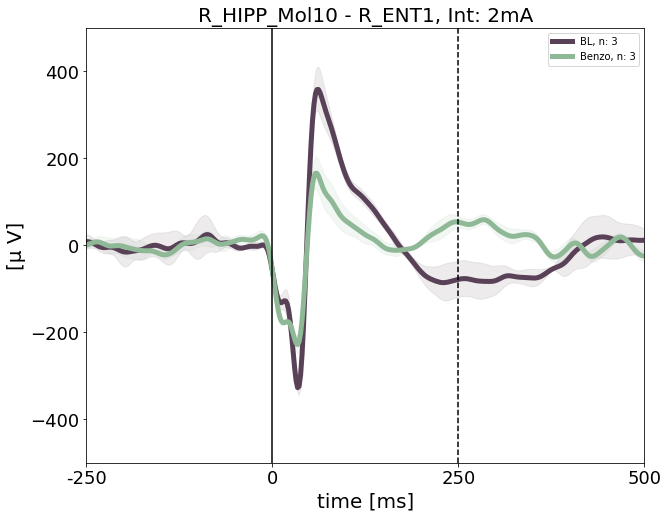

In [119]:
sc = 9
rc = 0
Int = 2
plt.figure(figsize=(10,8))
plt.title(labels_all[sc]+ ' - '+labels_all[rc]+', Int: '+str(Int)+'mA', fontsize=20)
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&(con_trial.Int==Int)]
    StimNum = dat.Num.values.astype('int')
    mn = np.mean(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
    st = np.std(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
    plt.plot(x_ax, mn, color=cond_colors[cond], linewidth=5, label = cond_labels[cond]+', n: '+str(len(dat)))
    plt.fill_between(x_ax, mn-st, mn+st, color=cond_colors[cond], alpha =0.1)
plt.xlim([-0.25,0.5])
plt.ylim([-500,500])
plt.axvline(0, color= [0,0,0])
plt.axvline(0.25, color= [0,0,0], linestyle= '--')
plt.legend()
plt.xticks([-0.25,0.,0.25,0.5], ['-250', '0', '250', '500'], fontsize=18)
plt.ylabel('[\u03BC V]', fontsize=20)
plt.xlabel('time [ms]', fontsize=20)
plt.yticks(fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\Fig2\\fig\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\Fig2\\fig\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'.jpg')
plt.show()

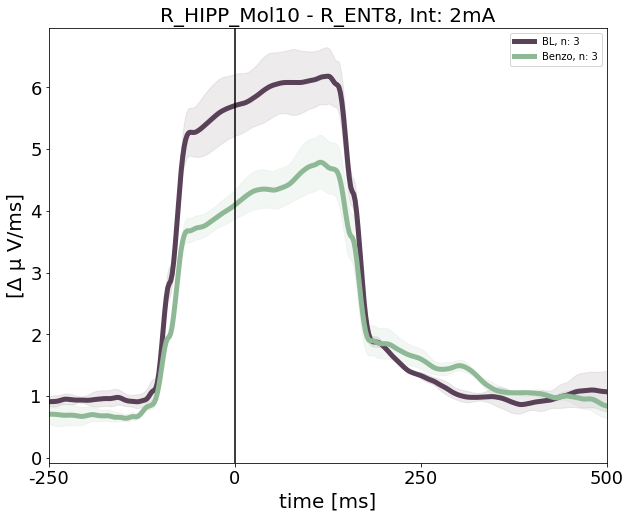

In [130]:
sc = 9
rc = 7
Int = 2
plt.figure(figsize=(10,8))
plt.title(labels_all[sc]+ ' - '+labels_all[rc]+', Int: '+str(Int)+'mA', fontsize=20)
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&(con_trial.Int==Int)]
    StimNum = dat.Num.values.astype('int')
    LL = LLf.get_LL_all(ff.lp_filter(EEG_resp[[[rc]], StimNum,:],40,Fs), Fs= Fs, win=0.25, t0=0, IPI=0)
    mn = np.mean(LL[0, :,:],0)
    st = np.std(LL[0, :,:],0)
    plt.plot(x_ax, mn, color=cond_colors[cond], linewidth=5, label = cond_labels[cond]+', n: '+str(len(dat)))
    plt.fill_between(x_ax, mn-st, mn+st, color=cond_colors[cond], alpha =0.1)
plt.xlim([-0.25,0.5])
#plt.ylim([-500,500])
plt.axvline(0, color= [0,0,0])
plt.legend()
plt.xticks([-0.25,0.,0.25,0.5], ['-250', '0', '250', '500'], fontsize=18)
plt.ylabel('[\u0394 \u03BC V/ms]', fontsize=20)
plt.xlabel('time [ms]', fontsize=20)
plt.yticks(fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\Fig2\\fig\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'_LL.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\Fig2\\fig\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'_LL.jpg')
plt.show()

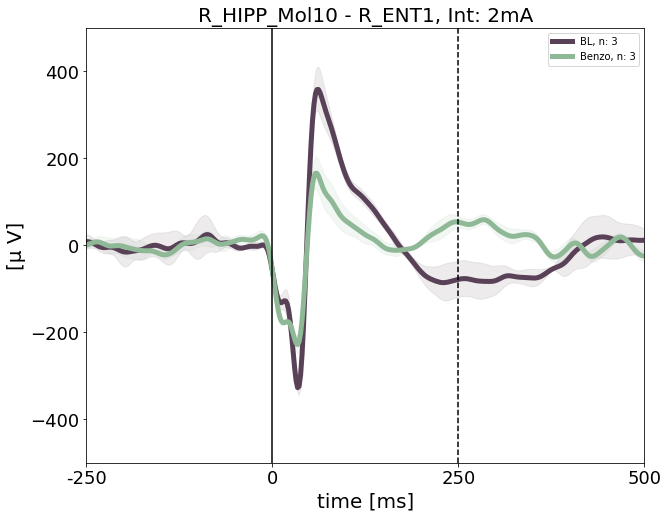

In [120]:
sc = 9
rc = 0
Int = 2
plt.figure(figsize=(10,8))
plt.title(labels_all[sc]+ ' - '+labels_all[rc]+', Int: '+str(Int)+'mA', fontsize=20)
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&(con_trial.Int==Int)]
    StimNum = dat.Num.values.astype('int')
    mn = np.mean(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
    st = np.std(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
    plt.plot(x_ax, mn, color=cond_colors[cond], linewidth=5, label = cond_labels[cond]+', n: '+str(len(dat)))
    plt.fill_between(x_ax, mn-st, mn+st, color=cond_colors[cond], alpha =0.1)
plt.xlim([-0.25,0.5])
plt.ylim([-500,500])
plt.axvline(0, color= [0,0,0])
plt.axvline(0.25, color= [0,0,0], linestyle= '--')
plt.legend()
plt.xticks([-0.25,0.,0.25,0.5], ['-250', '0', '250', '500'], fontsize=18)
plt.ylabel('[\u03BC V]', fontsize=20)
plt.xlabel('time [ms]', fontsize=20)
plt.yticks(fontsize=18)
#plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'.svg')
# plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'.jpg')
plt.show()

In [ ]:
sc = 9
rc = 0
plt.figure(figsize=(10,10))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition!=2)]
sns.lineplot(x='Int', y='LL', hue='Condition', data = dat, palette=['#594157', '#8FB996'], linewidth=5)
plt.xticks(fontsize=18)
plt.ylabel('[\u0394 \u03BC V/ms]', fontsize=20)
plt.xlabel('Int [mA]', fontsize=20)
plt.yticks(fontsize=18)
plt.legend(['BL', 'BZD'], fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')


In [ ]:
LL = dat.groupby(['Int'])['LL'].mean()

In [ ]:
sc = 9
rc = 1
plt.figure(figsize=(12,10))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())
    
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)]
    LL = dat.groupby(['Int'])['LL'].mean()
    plt.plot(np.unique(dat.Int), LL, color=cond_colors[cond], label=cond_labels[cond], linewidth=5, marker='o', markersize=10)
    plt.fill_between(np.unique(dat.Int), LL,np.zeros((len(np.unique(dat.Int)),))+LL_min, color=cond_colors[cond], alpha=0.3)
    
plt.xticks(fontsize=18)
plt.ylabel('[\u0394 \u03BC V/ms]', fontsize=20)
plt.xlabel('Int [mA]', fontsize=20)
plt.yticks(fontsize=18)
plt.legend(['BL', 'BZD'], fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')


In [ ]:
import sklearn

In [ ]:
sklearn.metrics.auc(np.unique(dat.Int), LL)

In [ ]:
sc = 9
rc = 4
plt.figure(figsize=(12,10))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())
    
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)]
    LL = dat.groupby(['Int'])['LL'].mean()/LL_max
    plt.plot(np.unique(dat.Int), LL, color=cond_colors[cond], label=cond_labels[cond], linewidth=5, marker='o', markersize=10)
    plt.fill_between(np.unique(dat.Int), LL,np.zeros((len(np.unique(dat.Int)),))+LL_min/LL_max, color=cond_colors[cond], alpha=0.3)
 

In [ ]:
-LL_min/LL_max

In [ ]:
val_min = np.min(dat.groupby([cond_sel, 'Int'])[Hs].median())
val_max = np.max(dat.groupby([cond_sel, 'Int'])[Hs].median())
AUC1 = np.trapz(np.repeat(val_max, len(Int_all)) - val_min, Int_all)

for cond in np.unique(dat[cond_sel]):
    dat_c = data[(data[cond_sel] == cond)]
    # todo: change to mean
    H_mean = dat_c.groupby('Int')[Hs].median().values
    ##  AUC
    AUC = np.trapz(H_mean - val_min, np.unique(dat_c.Int)) / AUC1
    NNMF_AUC = np.concatenate([NNMF_AUC, [[sc, j, 0, 0, cond, AUC, pc, len(dat_c)]]], axis=0)

In [ ]:
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
Int_all = np.unique(dat.Int)
LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())

AUC1 = np.trapz(np.repeat(LL_max, len(Int_all)) - LL_min, Int_all)

for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)]
    LL = dat.groupby(['Int'])['LL'].mean() # /LL_max
    AUC = np.trapz(LL - LL_min, Int_all) / AUC1 #sklearn.metrics.auc(np.unique(dat.Int), LL-LL_min/LL_max)
    print(AUC)

In [ ]:
AUC_all = np.zeros((1,4))
for sc in np.unique(con_trial.Stim).astype('int'):
    for rc in np.unique(con_trial.Chan).astype('int'):
        dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
        Int_all = np.unique(dat.Int)
        LL = dat.groupby(['Int'])['LL'].mean() # /LL_max

        if np.max(LL)/np.min(LL)>3:

            LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
            dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
            LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())

            AUC1 = np.trapz(np.repeat(LL_max, len(Int_all)) - LL_min, Int_all)

            for cond in [1,3]:
                dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&~np.isnan(con_trial.LL)]
                if len(dat)>0:
                    LL = dat.groupby(['Int'])['LL'].mean() # /LL_max
                    AUC = np.trapz(LL - LL_min, np.unique(dat.Int.values))/ AUC1 #sklearn.metrics.auc(np.unique(dat.Int), LL-LL_min/LL_max)

                    auc_sing = [[sc,rc,AUC,cond]]
                    AUC_all = np.concatenate([AUC_all, auc_sing])
AUC_all = AUC_all[1:,:]
AUC_all = pd.DataFrame(AUC_all, columns=['Stim','Chan','AUC','Condition'])

AUC_all.insert(0,'Resp_Area','hipp')
AUC_all.insert(0,'Stim_Area','hipp')
for sc in np.unique(AUC_all[['Stim', 'Chan']]).astype('int'):
    AUC_all.loc[AUC_all.Stim==sc,'Stim_Area'] =lbls.Area.values[sc]
    AUC_all.loc[AUC_all.Chan==sc,'Resp_Area'] =lbls.Area.values[sc]
AUC_all = AUC_all[AUC_all.AUC>0]
AUC_all.to_csv('Y:\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\'+subj+'_AUC_all.csv', header=True, index=False)

In [ ]:
sns.catplot(x='Condition', y= 'AUC', hue='Stim_Area', data=AUC_all)

In [ ]:
sc = 56
rc = 4
plt.figure(figsize=(12,10))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)

dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
Int_all = np.unique(dat.Int)
LL_min = np.min(dat.groupby(['Int', 'Condition'])['LL'].mean())
dat = con_trial[(con_trial.Int==10)&(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==1)]
LL_max = np.max(dat.groupby(['Int', 'Condition'])['LL'].mean())
AUC1 = np.trapz(np.repeat(LL_max, len(Int_all)) - LL_min, Int_all)
    
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)]
    
    LL = dat.groupby(['Int'])['LL'].mean()/LL_max
    AUC = np.trapz(LL*LL_max - LL_min, Int_all) / AUC1
    plt.plot(np.unique(dat.Int), LL, color=cond_colors[cond], label=cond_labels[cond]+', AUC: '+str(np.round(AUC,2)), linewidth=5, marker='o', markersize=10)
    plt.fill_between(np.unique(dat.Int), LL,np.zeros((len(np.unique(dat.Int)),))+LL_min/LL_max, color=cond_colors[cond], alpha=0.3)
    
plt.xticks(fontsize=18)
plt.ylabel('normalized LL', fontsize=20)
plt.xlabel('Int [mA]', fontsize=20)
plt.yticks([0.2,0.4, 0.6, 0.8, 1],fontsize=18)
plt.ylim([0.1,1.1])
plt.legend(loc='lower right',fontsize=18)
# plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IOnorm_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
# plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IOnorm_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
plt.show()

In [ ]:
sc = 9
rc = 0
plt.figure(figsize=(10,10))
plt.title(labels_all[sc]+ ' - '+labels_all[rc], fontsize=20)
dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition!=2)]
sns.lineplot(x='Int', y='LL', hue='Condition', data = dat, palette=['#594157', '#8FB996'], linewidth=5)
plt.xticks(fontsize=18)
plt.ylabel('[\u0394 \u03BC V/ms]', fontsize=20)
plt.xlabel('Int [mA]', fontsize=20)
plt.yticks(fontsize=18)
plt.legend(['BL', 'BZD'], fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\IO_' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')


In [ ]:
sc = 9
rc = 48
Int = 8
plt.figure(figsize=(10,8))
plt.title(labels_all[sc]+ ' - '+labels_all[rc]+', Int: '+str(Int)+'mA', fontsize=20)
for cond in [1,3]:
    dat = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Condition==cond)&(con_trial.Int==Int)]
    StimNum = dat.Num.values.astype('int')
    mn = np.mean(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
    st = np.std(ff.lp_filter(EEG_resp[rc, StimNum,:],40,Fs),0)
    plt.plot(x_ax, mn, color=cond_colors[cond], linewidth=5, label = cond_labels[cond]+', n: '+str(len(dat)))
    plt.fill_between(x_ax, mn-st, mn+st, color=cond_colors[cond], alpha =0.1)
plt.xlim([-0.25,0.5])
plt.ylim([-500,500])
plt.axvline(0, color= [0,0,0])
plt.axvline(0.25, color= [0,0,0], linestyle= '--')
plt.legend()
plt.xticks([-0.25,0.,0.25,0.5], ['-250', '0', '250', '500'], fontsize=18)
plt.ylabel('[\u03BC V]', fontsize=20)
plt.xlabel('time [ms]', fontsize=20)
plt.yticks(fontsize=18)
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'.svg')
plt.savefig('Y:\\eLab\EvM\Projects\EL_experiment\GABA_figures\single_Int\\' +subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_Int'+str(Int)+'.jpg')
plt.show()

In [ ]:
dat

In [ ]:
con_trial

In [ ]:
stop

In [ ]:
plot_raw_LL_IO_cond(0, 3, con_trial,EEG_resp,0,labels_all,  path_patient)

In [ ]:
def plot_Ints_IO(sc, rc, LL_CCEP,EEG_resp, labels_all):
    lists   = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]#&(LL_CCEP['Int']==Int)
    lists          = lists[~np.isnan(lists.LL.values)]
    stimNum_all    = lists.Num.values.astype('int')
    Int_all = np.unique(lists.Int)
    colors_Int = np.zeros((len(Int_all), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_all))
    fig   = plt.figure(figsize=(24,8) )
    gs       = fig.add_gridspec(1,2,width_ratios=[2,1])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)] , y=0.95)
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels_all[sc]+' -- '+labels_all[rc])#+', Dist: '+str(np.round(lists.d.values[0]))+'mm'
    ax = fig.add_subplot(gs[0,0])
    plt.xlim([-0.5,1.5])
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    limy = 600
    for i in range(len(Int_all)):
        list_Int = lists[lists.Int==Int_all[i]]
        stimNum_all                  = list_Int.Num.values.astype('int')
        plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=colors_Int[i], linewidth=1.5)
        lim= np.min([800, np.max(abs(np.mean(EEG_resp[rc,stimNum_all,:],0)))*1.1])
        limy = np.max([limy, lim])
    plt.ylim([-limy,limy])
    ax = fig.add_subplot(gs[0,1])
    #sns.set_palette(sns.color_palette(colors_Int))
    sns.scatterplot(x = 'Int', y= 'LL_peak',  data= lists)
    # plt.ylim([0,10])
    plt.show()

In [ ]:
def plot_Ints_IO_cond(sc, rc, LL_CCEP,EEG_resp, labels_all):
    fig   = plt.figure(figsize=(20,8) )
    gs       = fig.add_gridspec(1,3)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)] , y=0.98,fontsize=20)
    k=0
    for cond in [1,3]:
        lists   = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==cond)]#&(LL_CCEP['Int']==Int)
        lists          = lists[~np.isnan(lists.LL.values)]
        stimNum_all    = lists.Num.values.astype('int')
        Int_all = np.unique(lists.Int)
        colors_Int = np.zeros((len(Int_all), 3))
        colors_Int[:, 0] = np.linspace(0, 1, len(Int_all))
        
        #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
        #plt.title(labels_all[sc]+' -- '+labels_all[rc])#+', Dist: '+str(np.round(lists.d.values[0]))+'mm'
        ax = fig.add_subplot(gs[0,k])
        plt.xlim([-0.5,1])
        plt.xticks([-0.5,0,0.5,1],fontsize=20)
        plt.axvline(0, c=[0,0,0])
        plt.xlabel('time [s]',fontsize=20)
        plt.title(cond_labels[cond], fontsize=25)
        limy = 200
        plt.yticks(fontsize=20)
        for i in range(len(Int_all)):
            list_Int = lists[lists.Int==Int_all[i]]
            stimNum_all                  = list_Int.Num.values.astype('int')
            plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),40,Fs), c=colors_Int[i], linewidth=1.5)
            lim= np.min([800, np.max(abs(np.mean(EEG_resp[rc,stimNum_all,:],0)))*1.1])
            limy = np.max([limy, lim])
        plt.ylim([-limy,limy])
        k = k+1
    # plt.ylim([0,10])
    lists   = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]#&(LL_CCEP['Int']==Int)
    lists          = lists[~np.isnan(lists.LL.values)]
    ax = fig.add_subplot(gs[0,2])
        #sns.set_palette(sns.color_palette(colors_Int))
    sns.scatterplot(x = 'Int', y= 'LL_peak',hue='Condition',  data= lists)
    plt.xticks(np.arange(0,13,2),fontsize=20)
    plt.ylabel('peak LL [250ms]',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Intensity [mA]', fontsize=20)
    plt.tight_layout()

In [ ]:
plot_Ints_IO_cond(9, 1, con_trial,EEG_resp, labels_all)

In [ ]:
sc = 22
for rc in np.where((W_coeff.H1>np.percentile(W_coeff.H1,70)))[0].astype('int'):
    plot_raw_LL_IO_cond(sc, rc, con_trial,EEG_resp,chan_thr,labels_all,  path_patient)

In [ ]:
plot_raw_LL_IO_cond(33, 0, con_trial,EEG_resp,chan_thr,labels_all,  path_patient)

In [ ]:
plot_raw_LL_IO_cond(sc, rc, LL_all,EEG_resp,chan_thr,labels_all,path_patient)

In [ ]:
sc = 33
for rc in np.where((W_coeff.H2>np.percentile(W_coeff.H2,70)))[0].astype('int'):
    plot_raw_LL_IO_cond(sc, rc, con_trial,EEG_resp,chan_thr,labels_all,  path_patient)

In [ ]:
sc = 33
for rc in np.where((W_coeff.H2>np.percentile(W_coeff.H2,70)))[0].astype('int'):
    plot_raw_LL_IO_cond(sc, rc, con_trial,EEG_resp,chan_thr,labels_all,  path_patient)

In [ ]:
stop

In [ ]:
t_0 = 1
LL_mean     = get_LL_mean(EEG_resp, LL_CCEP, chan_thr, labels_all, labels_region, 'Condition', path_patient)
    

In [ ]:
Int_all = np.unique(stimlist.Int_prob)
color_int      = np.zeros((len(Int_all),3))
color_int[:,0] = np.linspace(0, 1, len(Int_all))
v= np.sort(labels_region)
region_border = np.where(np.roll(v,1)!=v)[0]
region_border = np.concatenate([region_border, [len(labels_all)]])
region_num = np.diff(region_border)
labels_sort     = labels_all[np.argsort(labels_region)]
labels_region_sort = np.sort(labels_region)
StimChanIx_sort = np.argsort(labels_region)

In [ ]:
file = path_patient + '/Analysis/InputOutput/LL/data/chan_sig_thr.csv'
if os.path.isfile(file):
    chan_thr    = pd.read_csv(file).values

In [ ]:
con_trial

In [ ]:
labels_all = lbls.Hemisphere+'_'+lbls.label

In [ ]:
labels_all = labels_all.values[:]

In [ ]:
plot_raw_LL_IO_cond(44, 50, con_trial,EEG_resp_Ph,np.zeros((len(labels_all),4)),labels_all,  path_patient)

In [ ]:
def plot_raw_LL_IO_cond(sc, rc, LL_all,EEG_resp,chan_thr,labels_all,path_patient):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)&(LL_all['LL']>0)]
    conds    = [1,3] #np.unique(dat.Condition)
    w        = 0.25
    fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(len(conds),3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(len(conds)):
        axs[2*i+0] = fig.add_subplot(gs[i, 0])
        axs[2*i+1] = fig.add_subplot(gs[i, 1])

    axIO   = fig.add_subplot(gs[:, 2])
    plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_CCEP        = 200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    mx_LL = 1
    LL0 = 3
    for j in range(len(conds)):
        con_sel = np.int64(conds[j])
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
            if len(dati)>0:
                resp             = np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
                LL_resp,mx,max_ix, sig  = sig_resp(resp, chan_thr[rc,1])
                mx = np.max(ff.lp_filter(LL_resp,45,Fs))
                axs[0+2*j].plot( x_ax,ff.lp_filter(resp,45,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[0+2*j].set_xlim(-0.2, 0.5)
                axs[1+2*j].plot( x_ax,ff.lp_filter(LL_resp,45,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                #axs[1+2*j].plot(0.01+w/2+max_ix/Fs,mx, marker='+', c = [0,0,0], alpha=0.7+0.3*sig, markersize= 10)
                axs[1+2*j].set_xlim(-0.3, 0.7)
                #axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)

                axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
                limy_LL = np.nanmax([limy_LL, np.max(ff.lp_filter(LL_resp,45,Fs))])
                limy_CCEP = np.nanmax([limy_CCEP, np.max(abs(resp))])
                mx_LL = np.max([mx_LL, mx])
                LL0 = np.min([LL0, mx])
        #y = (data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'LL norm']*data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'Sig']).values
        #y = (LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Condition==con_sel), 'LL norm']).values- LL0

        axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=1, label= cond_labels[con_sel])

    for i in range(len(conds)*2):
        axs[i].axvline(0, c=[0,0,0])


    axIO.legend(loc='lower right')
    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.axhline(LL0, color="black", linestyle="--")
    axs[0].set_title('mean CCEP')
    axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
    for i in range(len(conds)):
        axs[2*i].set_ylabel(cond_labels[np.int64(conds[i])])
        axs[2*i].set_ylim(-limy_CCEP,limy_CCEP)
        axs[2*i+1].set_ylim(0,1.2*limy_LL)

    axs[2].set_xlabel('time [s]')
    axs[3].set_xlabel('time [s]')

    plt.savefig(path_patient + '/InputOutput/Ph/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig(path_patient + '/InputOutput/Ph/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.show()
    #plt.close(fig)

In [ ]:
def plot_raw_LL_IO_cond(sc, rc, LL_all,EEG_resp,chan_thr,labels_all,path_patient):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)&(LL_all['LL']>0)]
    conds    = [1,3] #np.unique(dat.Condition)
    w        = 0.25
    fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(len(conds),3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(len(conds)):
        axs[2*i+0] = fig.add_subplot(gs[i, 0])
        axs[2*i+1] = fig.add_subplot(gs[i, 1])

    axIO   = fig.add_subplot(gs[:, 2])
    plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_CCEP        = 200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    mx_LL = 1
    LL0 = 3
    for j in range(len(conds)):
        con_sel = np.int64(conds[j])
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
            if len(dati)>0:
                resp             = np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
                LL_resp,mx,max_ix, sig  = sig_resp(resp, chan_thr[rc,1])
                mx = np.max(ff.lp_filter(LL_resp,45,Fs))
                axs[0+2*j].plot( x_ax,ff.lp_filter(resp,45,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[0+2*j].set_xlim(-0.2, 0.5)
                axs[1+2*j].plot( x_ax,ff.lp_filter(LL_resp,45,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                #axs[1+2*j].plot(0.01+w/2+max_ix/Fs,mx, marker='+', c = [0,0,0], alpha=0.7+0.3*sig, markersize= 10)
                axs[1+2*j].set_xlim(-0.3, 0.7)
                #axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)

                axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
                limy_LL = np.nanmax([limy_LL, np.max(ff.lp_filter(LL_resp,45,Fs))])
                limy_CCEP = np.nanmax([limy_CCEP, np.max(abs(resp))])
                mx_LL = np.max([mx_LL, mx])
                LL0 = np.min([LL0, mx])
        #y = (data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'LL norm']*data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'Sig']).values
        #y = (LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Condition==con_sel), 'LL norm']).values- LL0

        axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=1, label= cond_labels[con_sel])

    for i in range(len(conds)*2):
        axs[i].axvline(0, c=[0,0,0])


    axIO.legend(loc='lower right')
    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.axhline(LL0, color="black", linestyle="--")
    axs[0].set_title('mean CCEP')
    axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
    for i in range(len(conds)):
        axs[2*i].set_ylabel(cond_labels[np.int64(conds[i])])
        axs[2*i].set_ylim(-limy_CCEP,limy_CCEP)
        axs[2*i+1].set_ylim(0,1.2*limy_LL)

    axs[2].set_xlabel('time [s]')
    axs[3].set_xlabel('time [s]')

    plt.savefig(path_patient + '/Analysis/InputOutput/Ph/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig(path_patient + '/Analysis/InputOutput/Ph/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    #plt.show()
    plt.close(fig)

In [ ]:
def plot_raw_LL_IO_cond(sc, rc, LL_all, LL_mean,EEG_resp,chan_thr,labels_all,  path_patient):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    conds    = [1,3] #np.unique(dat.Condition)
    w        = 0.25
    fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(len(conds),3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(len(conds)):
        axs[2*i+0] = fig.add_subplot(gs[i, 0])
        axs[2*i+1] = fig.add_subplot(gs[i, 1])

    axIO   = fig.add_subplot(gs[:, 2])
    plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_CCEP        = 200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    LL0              = np.min((LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc), 'LL norm']).values)
    mx_LL =1
    for j in range(len(conds)):
        con_sel = np.int64(conds[j])
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
            if len(dati)>0:
                resp             = np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
                LL_resp,mx,max_ix, sig  = sig_resp(resp, chan_thr[rc,1])
                mx_norm = LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Int==Int_selc[i])&(LL_mean.Condition==con_sel), 'LL norm']
                sig = np.mean(LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Int==Int_selc[i])&(LL_mean.Condition==con_sel), 'Sig'])
                axs[0+2*j].plot( x_ax,ff.lp_filter(resp,40,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[0+2*j].set_xlim(-0.2, 0.5)
                axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[1+2*j].plot(0.01+w/2+max_ix/Fs,mx, marker='+', c = [0,0,0], alpha=0.7+0.3*sig, markersize= 10)
                axs[1+2*j].set_xlim(-0.2, 0.5)
                #axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)

                axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
                limy_LL = np.nanmax([limy_LL, mx])
                limy_CCEP = np.nanmax([limy_CCEP, np.max(abs(resp))])
                mx_LL = np.max([mx_LL, mx_norm.values[0]])
        #y = (data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'LL norm']*data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'Sig']).values
        y = (LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Condition==con_sel), 'LL norm']).values- LL0

        axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig, label= cond_labels[con_sel]+', AUC (%): '+str(np.round(trapz(y, Int_selc)/np.max(Int_selc),2)))

    for i in range(len(conds)*2):
        axs[i].axvline(0, c=[0,0,0])


    axIO.legend(loc='lower right')
    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.axhline(LL0, color="black", linestyle="--")

    axs[0].set_title('mean CCEP')
    axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
    for i in range(len(conds)):
        axs[2*i].set_ylabel(cond_labels[np.int64(conds[i])])
        axs[2*i].set_ylim(-limy_CCEP,limy_CCEP)
        #axs[2*i].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
    for i in range(len(conds)):
        #axs[2*i+1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
        axs[2*i+1].set_ylim(0,1.2*limy_LL)
    axs[2].set_xlabel('time [s]')
    axs[3].set_xlabel('time [s]')

    plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.show()

In [ ]:
def get_peaks_ccep(LL_CCEP, EEG_resp,t_0=1, Fs=500):
    new_lab  = ['N1','N2','P2','sN1','sN2','sP2']
    for l in new_lab:
        if l not in LL_CCEP:
            LL_CCEP.insert(9, l,np.nan)
    data    =  LL_CCEP[~(np.isnan(LL_CCEP.LL.values))]

    for sc in np.unique(data.Stim).astype('int'):
        for rc in np.unique(data.loc[data.Stim==sc, 'Chan']).astype('int'):
            StimNum = data.loc[(data.Int>5)&(data.Stim==sc)&(data.Chan==rc), 'Num'].values.astype('int')
            if len(StimNum)>4:
                
                resp_all                  = bf.zscore_CCEP(np.mean(ff.lp_filter(EEG_resp[rc,StimNum,:],45,Fs),0))
                if np.max(abs(resp_all))>5:
                ## get start resp
                    peaks_all, properties_all = scipy.signal.find_peaks(abs(resp_all[int(t_0*Fs):int((t_0+0.5)*Fs)]), height=1.5, prominence=0.05,distance=0.03*Fs, width=1)#

                    if len(peaks_all)>0:
                        peaks_all = peaks_all[0]
                        w = scipy.signal.peak_widths(abs(resp_all[int(t_0*Fs):int((t_0+0.5)*Fs)]), [peaks_all], rel_height=0.5)[0]

                        start_resp = (peaks_all-w)/Fs-0.01

                    if start_resp< 0.01:
                        start_resp = 0


                    pk,peak_s, p     = LLf.get_peaks_all(resp_all,start_resp)
                    pk_all = resp_all[pk]
                    # p          = 1 # polarity of N1, N2 peaks
                    # if pk_all[0,1]<pk_all[1,1]:
                    #     p=-1
               
                    StimNum = data.loc[(data.Stim==sc)&(data.Chan==rc), 'Num'].values.astype('int')
                    for i in range(len(StimNum)):
                        resp_raw    = ff.lp_filter(EEG_resp[rc,StimNum[i],:],40,Fs)
                        peaks       = LLf.get_peaks_trial(resp_raw,peak_s, p = p, t_0=1, Fs=500)
                        slope       = LLf.pk_lin_fit(resp_raw, peaks, fig=0, t_0 =1, Fs = 500)

                        LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'N1'] = abs(peaks[1,1]-peaks[0,1])
                        LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'N2'] = abs(peaks[1,1]-peaks[2,1])
                        LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'P2'] = abs(peaks[3,1]-peaks[2,1])
                        LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), ['sN1', 'sN2','sP2']] = slope
                        # LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'sN2'] = abs(peaks[1,1]-peaks[2,1])
                        # LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'sP2'] = abs(peaks[3,1]-peaks[2,1])
                    # for l in ['N1', 'N2']:
                    #     m = np.mean(LL_CCEP.loc[(LL_CCEP.Condition == 1)&(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), l])
                    #     LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), 'n'+l] = LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), l]/m
    return LL_CCEP

In [ ]:
stop

In [ ]:
Stims

In [ ]:
Stims = np.unique(LL_mean.Stim)
s = 0

In [ ]:
Stims

In [ ]:
t_0        = 1 
# sc        = 0
# rc        = 2
sc         = int(Stims[0])
data_sel           =  LL_mean[(LL_mean.Stim==sc)&(LL_mean.N1>100)]

#sc              = data_sel.Stim.values[s].astype('int')
rc              = int(np.unique(data_sel.Chan)[s])
s               = s+1#np.random.randint((len(data_sel)))

data_plot       = LL_CCEP[(LL_CCEP.Stim ==sc)&(LL_CCEP.Chan ==rc)]
StimNum        = data_plot.loc[(data_plot.Int>5)&(data_plot.Stim==sc)&(data_plot.Chan==rc), 'Num'].values.astype('int')
resp_all                  = bf.zscore_CCEP(np.mean(ff.lp_filter(EEG_resp[rc,StimNum,:],45,Fs),0))
## get start resp
peaks_all, properties_all = scipy.signal.find_peaks(abs(resp_all[int(t_0*Fs):int((t_0+0.5)*Fs)]), height=1.5, prominence=0.05,distance=0.03*Fs, width=1)#

if len(peaks_all)>0:
    peaks_all = peaks_all[0]
    w = scipy.signal.peak_widths(abs(resp_all[int(t_0*Fs):int((t_0+0.5)*Fs)]), [peaks_all], rel_height=0.5)[0]

    start_resp = (peaks_all-w)/Fs-0.01

    if start_resp< 0.01:
        start_resp = 0


pk,peak_s, p     = LLf.get_peaks_all(resp_all,start_resp)
#pk_all = resp_all[pk]
#### FIGURE 
fig      = plt.figure(figsize=(15,15), facecolor='w', edgecolor='k')
Ints= [0.2, 1, 2,4, 8,10]

gs       = fig.add_gridspec(len(Ints),3)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(data_plot.d),1))+'mm', y=0.95)
cond_sel = [1,3]
for u in range(len(cond_sel)):
    cond = cond_sel[u]
    i = 0
    for Int in Ints:
        if (i ==0)&(u ==0):
            ax = fig.add_subplot(gs[i,u])
        else:
            fig.add_subplot(gs[i,u], sharey= ax)
        StimNum = data_plot.loc[(data_plot.Int==Int)&(LL_CCEP.Condition ==cond) , 'Num'].values.astype('int')
        #for j in range(len(StimNum)): 
        #resp_raw    = ff.lp_filter(EEG_resp[rc,StimNum[j],:],40,Fs)
        resp_raw    =np.mean(ff.lp_filter(EEG_resp[rc,StimNum,:],45,Fs),0)
        pk          = LLf.get_peaks_trial(resp_raw,peak_s, p = p, t_0=1, Fs=500)
        plt.plot(pk[:,0], pk[:,1], "^", color= [1,0,0])
        plt.plot(x_ax, resp_raw, c= cond_colors[cond], linewidth=2)
        plt.axvline(0, c=[0,0,0])
        plt.title(str(Int)+'mA')
        if u==0:
            plt.ylabel('[\u03BCV]')  
            
        plt.xlim([-0.2,1.5])
        if i <len(Ints)-1:
            plt.xticks([])

        i = i+1
    plt.xlabel('time [s]')
data_plot = LL_mean[(LL_mean.Stim ==sc)&(LL_mean.Chan ==rc)&~(LL_mean.Condition ==2)]


i =0
for l in ['LL', 'N1', 'N2']:
    fig.add_subplot(gs[i:i+2,2])
    sns.scatterplot(x="Int", y=l, data=data_plot[data_plot.Sig==1], hue="Condition",palette=[cond_colors[1],cond_colors[3]], alpha=1)
    sns.scatterplot(x="Int", y=l, data=data_plot[data_plot.Sig==0], hue="Condition",palette=[cond_colors[1],cond_colors[3]], alpha=0.5)
    plt.legend([],[], frameon=False)
    i = i+2
#, hue="Condition",palette=[cond_colors[1],cond_colors[3]]
    
    if l == 'LL':
        plt.ylabel(l + '[\u0394 \u03BCV/ms]')   
    else:
        plt.ylabel(l + '[\u0394 \u03BCV]')  
    plt.xlabel('')
plt.xlabel('Int [mA]')
plt.show()

In [ ]:
data_plot

In [ ]:
LL_CCEP

In [ ]:
sc = 9
rc = 0
plot_raw_LL_IO_cond(sc, rc, LL_CCEP, LL_mean,EEG_resp,chan_thr,labels_all,  path_patient)

In [ ]:
cond_labels[1] = 'CONTROL'
cond_labels[3] = 'BZD'

In [ ]:
def plot_Ints_IO(sc, rc, LL_CCEP,EEG_resp, labels_all, ss):
    lists   = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]#&(LL_CCEP['Int']==Int)
    lists          = lists[~np.isnan(lists.LL.values)]
    stimNum_all    = lists.Num.values.astype('int')
    Int_all = np.unique(lists.Int)
    colors_Int = np.zeros((len(Int_all), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_all))
    fig   = plt.figure(figsize=(24,8) )
    gs       = fig.add_gridspec(1,2,width_ratios=[2,1])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', Sleep: '+ss , y=0.95)
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels_all[sc]+' -- '+labels_all[rc])#+', Dist: '+str(np.round(lists.d.values[0]))+'mm'
    ax = fig.add_subplot(gs[0,0])
    plt.xlim([-0.5,1.5])
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    limy = 600
    for i in range(len(Int_all)):
        list_Int = lists[lists.Int==Int_all[i]]
        stimNum_all                  = list_Int.Num.values.astype('int')
        plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=colors_Int[i], linewidth=1.5)
        lim= np.min([800, np.max(abs(np.mean(EEG_resp[rc,stimNum_all,:],0)))*1.1])
        limy = np.max([limy, lim])
    plt.ylim([-limy,limy])
    ax = fig.add_subplot(gs[0,1])
    #sns.set_palette(sns.color_palette(colors_Int))
    sns.scatterplot(x = 'Int', y= 'LL_peak',  data= lists)
    # plt.ylim([0,10])
    plt.show()

In [ ]:
def plot_raw_LL_IO_cond(sc, rc, LL_all, LL_mean,EEG_resp,chan_thr,labels_all,  path_patient):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    conds    = [1,3] #np.unique(dat.Condition)
    w        = 0.25
    fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(len(conds),3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(len(conds)):
        axs[2*i+0] = fig.add_subplot(gs[i, 0])
        axs[2*i+1] = fig.add_subplot(gs[i, 1])

    axIO   = fig.add_subplot(gs[:, 2])
    plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_CCEP        = 200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    LL0              = np.min((LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc), 'LL norm']).values)
    mx_LL =1
    for j in range(len(conds)):
        con_sel = np.int64(conds[j])
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
            if len(dati)>0:
                resp             = np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
                LL_resp,mx,max_ix, sig  = IOF.sig_resp(resp, chan_thr[rc,1])
                mx_norm = LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Int==Int_selc[i])&(LL_mean.Condition==con_sel), 'LL norm']
                sig = np.mean(LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Int==Int_selc[i])&(LL_mean.Condition==con_sel), 'Sig'])
                axs[0+2*j].plot( x_ax,ff.lp_filter(resp,40,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[0+2*j].set_xlim(-0.2, 0.5)
                axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[1+2*j].plot(0.01+w/2+max_ix/Fs,mx, marker='+', c = [0,0,0], alpha=0.7+0.3*sig, markersize= 10)
                axs[1+2*j].set_xlim(-0.2, 0.5)
                #axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)

                axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
                limy_LL = np.nanmax([limy_LL, mx])
                limy_CCEP = np.nanmax([limy_CCEP, np.max(abs(resp))])
                mx_LL = np.max([mx_LL, mx_norm.values[0]])
        #y = (data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'LL norm']*data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'Sig']).values
        y = (LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Condition==con_sel), 'LL norm']).values- LL0

        axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig, label= cond_labels[con_sel]+', AUC (%): '+str(np.round(trapz(y, Int_selc)/np.max(Int_selc),2)))

    for i in range(len(conds)*2):
        axs[i].axvline(0, c=[0,0,0])

    #b.set_xlabel('Connection Distance',fontsize=20)
    # b.set_title('Hippocampus Stimulation (across 3 patients)',fontsize=20)
    # b.set_ylabel('AUC Ratio (BZD/Control)',fontsize=20)

    axIO.legend(loc='lower right')
    axIO.set_title('IO curve',fontsize=18)
    axIO.set_ylabel('LL uv/ms [250ms] normalized',fontsize=16)
    axIO.set_xlabel('Intensity [mA]',fontsize=16)
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.axhline(LL0, color="black", linestyle="--")

    axs[0].set_title('mean CCEP',fontsize=18)
    axs[1].set_title('LL ['+str(w)+'s] of mean CCEP',fontsize=18)
    for i in range(len(conds)):
        axs[2*i].set_ylabel(cond_labels[np.int64(conds[i])],fontsize=16)
        axs[2*i].set_ylim(-limy_CCEP,limy_CCEP)
        #axs[2*i].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
    for i in range(len(conds)):
        #axs[2*i+1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
        axs[2*i+1].set_ylim(0,1.2*limy_LL)
    axs[2].set_xlabel('time [s]',fontsize=16)
    axs[3].set_xlabel('time [s]',fontsize=16)

    plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.close(fig)#plt.show()

In [ ]:
sc        = 56
rc        = 18
data_plot = LL_CCEP[(LL_CCEP.Stim ==sc)&(LL_CCEP.Chan ==rc) &(LL_CCEP.Condition ==1)]
StimNum = data_plot.loc[(data_plot.Int>5)&(data_plot.Stim==sc)&(data_plot.Chan==rc), 'Num'].values.astype('int')
resp_all   = np.mean(ff.lp_filter(bf.zscore_CCEP(EEG_resp[rc,StimNum,:]),45,Fs),0)
pk_all     = get_peaks(resp_all)
p          = 1 # polarity of N1, N2 peaks
if pk_all[0,1]<pk_all[1,1]:
    p=-1
                    
fig      = plt.figure(figsize=(10,15), facecolor='w', edgecolor='k')
Ints= [0.2, 1, 2,4, 8,10]

gs       = fig.add_gridspec(len(Ints),2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(data_plot.d),1))+'mm', y=0.95)
i = 0
for Int in Ints:
    if i ==0:
        ax = fig.add_subplot(gs[i,0])
    else:
        fig.add_subplot(gs[i,0], sharey= ax)
    StimNum = data_plot.loc[(data_plot.Int==Int) , 'Num'].values.astype('int')
    for j in range(len(StimNum)): 
        resp_raw    = ff.lp_filter(EEG_resp[rc,StimNum[j],:],40,Fs)
        pk       = LLf.get_peaks_trial(resp_raw,pk_all[:,0], p = p, t_0=1, Fs=500)
        plt.plot(pk[:3,0], pk[:3,1], "^", color= [1,0,0])
        plt.plot(x_ax, resp_raw, c= color_elab[0])
    plt.axvline(0, c=[0,0,0])
    plt.title(str(Int)+'mA')
    plt.ylabel('[\u03BCV]')  
    plt.xlim([-0.2,1.5])
    if i <len(Ints)-1:
        plt.xticks([])

    i = i+1
plt.xlabel('time [s]')
data_plot = con_trial[(con_trial.Stim ==sc)&(con_trial.Chan ==rc) &(con_trial.Condition ==1)]


i =0
for l in ['LL', 'N1', 'N2']:
    fig.add_subplot(gs[i:i+2,1])
    sns.scatterplot(x="Int", y=l, data=data_plot)
    i = i+2
#, hue="Condition",palette=[cond_colors[1],cond_colors[3]]
    
    if l == 'LL':
        plt.ylabel(l + '[\u0394 \u03BCV/ms]')   
    else:
        plt.ylabel(l + '[\u0394 \u03BCV]')  
    plt.xlabel('')
plt.xlabel('Int [mA]')
plt.show()

In [ ]:
data_plot = con_trial[(con_trial.Stim ==sc)&(con_trial.Chan ==rc)&~(con_trial.Condition ==2) ]
fig      = plt.figure(figsize=(20, 6), facecolor='w', edgecolor='k')
    #
gs       = fig.add_gridspec(1,3)  # GridSpec(4,1, height_ratios=[1,2,1,2])
#plt.suptitle(subj)
plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(data_plot.d),1))+'mm', y=0.95)
    
i =0
for l in ['LL', 'N1', 'N2']:
    fig.add_subplot(gs[0,i])
    sns.scatterplot(x="Int", y=l, data=data_plot, hue = 'Condition',palette=[cond_colors[1],cond_colors[3]])
    i = i+1
#, hue="Condition",palette=[cond_colors[1],cond_colors[3]]
    plt.xlabel('Int [mA]')
    if l == 'LL':
        plt.ylabel(l + '[\u0394 \u03BCV/ms]')   
    else:
        plt.ylabel(l + '[\u0394 \u03BCV]')   
# plt.xlabel('N1 - P1 [\u0394 \u03BCV/ms]')
# plt.ylabel('N2 - P1 [\u0394 \u03BCV/ms]') 
#plt.savefig(path_patient + '/Analysis/BrainMapping/CCEP/Ph/figures/P2P_N1_N2.jpg')
plt.show()

In [ ]:

IOF.plot_raw_LL_IO_cond(sc, rc, LL_CCEP, LL_mean,EEG_resp,chan_thr,labels_all,  path_patient)

In [ ]:
stop

## Analysis

In [ ]:
IO_summary_Hipp[(IO_summary_Hipp.Condition.isin([1,3]))&(IO_summary_Hipp.Stim == stims[i])&(IO_summary_Hipp.MPI <5)]

In [ ]:
IO_summary_Hipp[IO_summary_Hipp.Stim=='R_HIPP_Mol10']

In [ ]:
IO_summary_Hipp.insert(5,'AUCn', 0)


In [ ]:
len(subjs)

In [ ]:
colors_subj = np.zeros((len(stims),3))
colors_subj[1,0] =1
colors_subj[2,1] =1
colors_subj[3,2] =1
colors_subj[4,0:2] =[1,1]

In [ ]:
color_stims = []

In [ ]:
color_stims.append('#8ba9b6')

In [ ]:
color_stims

In [ ]:
IO_summary_Hipp[IO_summary_Hipp.Stim == 'L_HippMol_head34']

In [ ]:
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:5])

In [ ]:
ax = [0,1]

stims = np.unique(IO_summary_Hipp.Stim)
plt.figure(figsize=(5,10))
for i in range(len(stims)):
    data = IO_summary_Hipp[(IO_summary_Hipp.RespR != 'WM')&(IO_summary_Hipp.Condition.isin([1,3]))&(IO_summary_Hipp.Stim == stims[i])&(IO_summary_Hipp.MPI <8)]
    resp = np.unique(data.Resp)
    for j in range(len(resp)):
        if len(data.loc[(data.Resp==resp[j]), 'AUC'].values)>1:
            ctr = data.loc[(data.Resp==resp[j])&(data.Condition==1), 'AUC'].values[0]
            if ctr>0.2:
                bzd = data.loc[(data.Resp==resp[j])&(data.Condition==3), 'AUC'].values[0]
                plt.plot(ax,[ctr,bzd], c= color_stims[i] )
        
plt.xticks([0,1],['Control', 'BZD'])
plt.ylabel('AUC')
plt.ylim([0,0.8])
#plt.savefig("T:\EL_experiment\Patients\\" +'all'+"\\Analysis\IO\\figures\\IO_BZD_acros.svg")
#plt.savefig("T:\EL_experiment\Patients\\" +'all'+"\\Analysis\IO\\figures\\IO_BZD_acros.png")

In [ ]:
IO_summary.to_csv("T:\EL_experiment\Patients\\" +'all'+"\\Analysis\IO\\summary_all.csv", index=False,
                  header=True) 

In [ ]:
plt.figure(figsize=(12,6))
sns.catplot(x ='Condition', y='AUC', hue='Stim', data=IO_summary_Hipp[(IO_summary_Hipp.RespR != 'WM')&(IO_summary_Hipp.Condition.isin([1,3]))&(IO_summary_Hipp.MPI <5)], kind="point")
sns.catplot(x ='Condition', y='AUC', hue='Stim', data=IO_summary_Hipp[(IO_summary_Hipp.RespR != 'WM')&(IO_summary_Hipp.Condition.isin([1,3]))&(IO_summary_Hipp.MPI <5)], kind="swarm")

In [ ]:
g = sns.factorplot(x="X_Axis", y="vals", hue='cols', data=df)

In [ ]:
path_patient

In [ ]:
sns.scatterplot(x='d', y= 'AUC', data= IO_summary_Hipp[~(IO_summary_Hipp.Condition==2)], hue='Condition')

In [ ]:
data_sel.loc[(data_sel.Condition==3), 'AUC']

In [ ]:
data_sel.loc[(data_sel.Condition==1), 'AUC'].values[0]

In [ ]:
data_sel.loc[(data_sel.Condition==3), 'AUC']/data_sel.loc[(data_sel.Condition==1), 'AUC']

In [ ]:
np.unique(data_sel.Condition)

In [ ]:
[1,3]

In [ ]:
dist_groups = np.array([[0,15],[15,30],[30,120]])
dist_labels = ['local (<15 mm)', 'short (<30mm)', 'long']

In [ ]:
BZD_ratio = np.zeros((1,5))
i = 0
for subj_sel in np.unique(IO_summary_Hipp.subj):
    for sc in np.unique(IO_summary_Hipp.loc[IO_summary_Hipp.subj==subj_sel, 'StimC']):
        for rc in np.unique(IO_summary_Hipp.loc[(IO_summary_Hipp.subj==subj_sel)&(IO_summary_Hipp.StimC==sc), 'RespC']): 
            data_sel = IO_summary_Hipp.loc[(IO_summary_Hipp.subj==subj_sel)&(IO_summary_Hipp.StimC==sc)&(IO_summary_Hipp.RespC==rc)]
            if (np.isin([1,3],np.unique(data_sel.Condition))).all():
                d        = np.mean(data_sel['d'])
                val        = np.zeros((1,5))
                val[0,0:4] = [i,sc, rc, d]
                val[0,4]   = data_sel.loc[(data_sel.Condition==3), 'AUC'].values[0]/data_sel.loc[(data_sel.Condition==1), 'AUC'].values[0]
            BZD_ratio = np.concatenate([BZD_ratio, val])
    i = i+1
BZD_ratio    = BZD_ratio[1:,:]
data_A = pd.DataFrame(BZD_ratio,columns=['sub_num', 'StimC', 'RespC', 'd', 'AUC Ratio'])  # , "Sig_Con": LL_mean[:, 7]
data_A.insert(4, 'Dist', 'local (<15 mm)')
for i in range(3):
    data_A.loc[(data_A.d>=dist_groups[i,0])&(data_A.d<dist_groups[i,1]), 'Dist'] = dist_labels[i]

In [ ]:
data_A.loc[data_A['AUC Ratio']>1.5, 'AUC Ratio'] = data_A.loc[data_A['AUC Ratio']>1.5, 'AUC Ratio']-0.7

In [ ]:
cond_colors[3]

In [ ]:
medians = data_A.groupby(['Dist'])['UC Ratio'].median()
vertical_offset = tips['total_bill'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [ ]:
dist_labels = ['local (<15 mm)', 'short (<30mm)', 'long']

In [ ]:
len(data_A[data_A.Dist=='long'])

In [ ]:
len(data_A[data_A.Dist=='short (<30mm)'])

In [ ]:
len(data_A[data_A.Dist=='local (<15 mm)'])

In [ ]:
data_A.groupby(['Dist'])['AUC Ratio'].mean()

In [ ]:
anp.sum(data_A.groupby(['Dist']))

In [ ]:
medians

In [ ]:
data_A = data_A.sort_values(by=['d'])
plt.figure(figsize=(22,12))
b = sns.boxplot(x= 'Dist', y='AUC Ratio', data= data_A, palette=[color_elab[2]], linewidth=8)
# plt.xlabel('Connection Distance')
# plt.ylabel('AUC Ratio (BZD/Control)')
plt.ylim([0,2])
plt.axhline(1, c=color_elab[0], linewidth=8)
plt.yticks([0,1,2])
b.set_xlabel('Connection Distance',fontsize=30)
#b.set_title('Hippocampus Stimulation (across 3 patients)',fontsize=20)
b.set_ylabel('AUC Ratio (BZD/Control)',fontsize=30)
b.tick_params(labelsize=30)
#plt.savefig('/Users/ellenvanmaren/Desktop/Insel/EL_experiment/AUC_Ratio.svg')
plt.show()

In [ ]:
sns.scatterplot(x='d', y='AUC Ratio', data= data_A)
plt.xlim([7,80])

In [ ]:
data_A = pd.DataFrame(BZD_ratio,columns=['sub_num', 'StimC', 'RespC', 'd', 'AUC Ratio'])  # , "Sig_Con": LL_mean[:, 7]
    

In [ ]:
BZD_ratio.shape

In [ ]:
IO_summary_Hipp

In [ ]:
subjs = ['EL003','EL004','EL005','EL008', 'EL010']
i=0
for subj in subjs:
    if platform.system()=='Windows':
        path_patient = 'T:\EL_experiment\Patients\\'+subj
    else: #'Darwin' for MAC
        path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subj
    file = path_patient + '/Analysis/InputOutput/LL/data/IO_mean_'+Condition+'.csv'
    if i ==0:
        IO_summary    = pd.read_csv(file)
        IO_summary.insert(0,'subj',subj)
    else:
        IOs = pd.read_csv(file)
        IOs.insert(0,'subj',subj)
        IO_summary = pd.concat([IO_summary, IOs])
    i =i+1
    
IO_summary.loc[IO_summary.StimR=='HIPP'  , 'StimR'] = 'Mesiotemporal'
IO_summary.loc[IO_summary.StimR=='HIPP ', 'StimR' ] = 'Mesiotemporal'
IO_summary.loc[IO_summary.StimR=='ENT'  , 'StimR'] = 'Basotemporal'

IO_summary.loc[IO_summary.StimR=='RespR'  , 'StimR'] = 'Mesiotemporal'
IO_summary.loc[IO_summary.StimR=='RespR ', 'StimR' ] = 'Mesiotemporal'
IO_summary.loc[IO_summary.StimR=='RespR'  , 'StimR'] = 'Basotemporal'

IO_summary.loc[(IO_summary.Stim =='L_OTS_med1'), 'Stim'] = 'L_Hipp1'
IO_summary.loc[(IO_summary.Stim =='L_Hipp1'), 'StimR'] = 'Mesiotemporal'

IO_summary_Hipp = IO_summary[IO_summary.StimR == 'Mesiotemporal']

### distance

In [ ]:
plot_AUC_dist(IO_summary_Hipp[(IO_summary_Hipp.RespR !='WM')&(IO_summary_Hipp.Stim =='R_HIPP_Mol10')], [1])

In [ ]:
plot_AUC_dist(IO_summary_Hipp[(IO_summary_Hipp.RespR !='WM')&(IO_summary_Hipp.subj =='EL010')&(IO_summary_Hipp.Stim =='L_Hipp1')], [1])

In [ ]:
plot_AUC_dist_cond(IO_summary_Hipp[(IO_summary_Hipp.RespR !='WM')&(IO_summary_Hipp.subj =='EL010')&(IO_summary_Hipp.Stim =='L_Hipp1')], [1,3])

In [ ]:
plot_AUC_dist_cond(IO_summary_Hipp[(IO_summary_Hipp.RespR !='WM')&(IO_summary_Hipp.Stim =='R_HIPP_Mol10')], [1,3])

In [ ]:
def plot_AUC_dist_cond(IO_all, cond_sel):
    MPI_lim   = 13
    IO_all    = IO_all[np.isin(IO_all.Condition, cond_sel)]
    x_lim     = 50#np.min([100, np.nanmax(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.Sig>=1), 'd'])])
    fig       = plt.figure(figsize=(x_lim/2.5, 4), facecolor='w', edgecolor='k')
    gs        = fig.add_gridspec(2,1,height_ratios=[5,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    stimlabel = IO_all.Stim.values[0]

    ## define axes , MPI  & AUC ~distance
    ax_AUC  = fig.add_subplot(gs[0, 0])
    ax_chan = fig.add_subplot(gs[-1, 0], sharex=ax_AUC)
    yAUC = 10
    # channels

    respchans  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.Condition==3)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'RespC'])
    respchans1  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.Condition==1)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'RespC'])
    respchans= np.intersect1d(respchans, respchans1)
    for j in range(len(cond_sel)):
        data_plot_stim     = IO_all[np.isin(IO_all.RespC,respchans)&(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.d>6.5)&(IO_all.Sig>=1)&(IO_all.Condition==cond_sel[j])]
        ax_AUC.scatter(data_plot_stim.d+j/5, data_plot_stim.AUC, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
        yAUC = np.max([yAUC, np.max(data_plot_stim.AUC)])

        # ax_MPI.scatter(data_plot_stim.d+j/5, data_plot_stim.MPI, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
        # yMPI = np.max([yMPI, np.max(data_plot_stim.MPI)])
    for i in range(len(data_plot_stim)):
        d = data_plot_stim.d.values[i]
        t = data_plot_stim.RespR.values[i]
        if d < x_lim:
            ax_chan.text(d,0, t,rotation=90)
    #labels
    #ax_MPI.set_ylabel('Minim Pulse Intensity [mA]')
    ax_AUC.set_xlabel('distance [mm]')
    ax_AUC.set_ylabel('AUC of IO curve (%)')
    ax_AUC.set_ylim([0,1])
    #ax_MPI.set_ylim([0,12])
    ax_AUC.set_xlim([5,x_lim])
    #ax_MPI.set_xlim([5,x_lim])
    # Design
    ax_AUC.grid()
    ax_chan.set_facecolor((1.0, 0.47, 0.42))
    ax_chan.axis('off')


    plt.savefig('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/IO/figures/Cond_AUC_'+stimlabel+'.svg')
    plt.savefig('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/IO/figures/Cond_AUC_'+stimlabel+'.jpg')
    plt.show()

In [ ]:
def plot_AUC_dist(IO_all, cond_sel):
    MPI_lim   = 13
    IO_all    = IO_all[np.isin(IO_all.Condition, cond_sel)]
    x_lim     = 70#np.min([100, np.nanmax(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.Sig>=1), 'd'])])
    fig       = plt.figure(figsize=(x_lim/2.5, 4), facecolor='w', edgecolor='k')
    gs        = fig.add_gridspec(2,1,height_ratios=[5,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])


    ## define axes , MPI  & AUC ~distance
    ax_AUC  = fig.add_subplot(gs[0, 0])
    ax_chan = fig.add_subplot(gs[-1, 0], sharex=ax_AUC)
    yAUC = 10
    # channels
    respchans  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'RespC'])
    # respchans  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.Condition==3)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'RespC'])
    # respchans1  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.Condition==1)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'RespC'])
    # respchans= np.intersect1d(respchans, respchans1)
    for j in range(len(cond_sel)):
        data_plot_stim     = IO_all[np.isin(IO_all.RespC,respchans)&(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.d>6.5)&(IO_all.Sig>=1)&(IO_all.Condition==cond_sel[j])]
        ax_AUC.scatter(data_plot_stim.d+j/5, data_plot_stim.AUC, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
        yAUC = np.max([yAUC, np.max(data_plot_stim.AUC)])

        # ax_MPI.scatter(data_plot_stim.d+j/5, data_plot_stim.MPI, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
        # yMPI = np.max([yMPI, np.max(data_plot_stim.MPI)])
    for i in range(len(data_plot_stim)):
        d = data_plot_stim.d.values[i]
        t = data_plot_stim.RespR.values[i]
        if d < x_lim:
            ax_chan.text(d,0, t,rotation=90)
    #labels
    #ax_MPI.set_ylabel('Minim Pulse Intensity [mA]')
    ax_AUC.set_xlabel('distance [mm]')
    ax_AUC.set_ylabel('AUC of IO curve (%)')
    ax_AUC.set_ylim([0,1])
    #ax_MPI.set_ylim([0,12])
    ax_AUC.set_xlim([5,x_lim])
    #ax_MPI.set_xlim([5,x_lim])
    # Design
    ax_AUC.grid()
    ax_chan.set_facecolor((1.0, 0.47, 0.42))
    ax_chan.axis('off')


    plt.savefig('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/IO/figures/BL_AUC_'+labels_all[sc]+'.svg')
    plt.show()

In [ ]:
MPI_lim = 13
IO_all = IO_all[np.isin(IO_all.Condition, [1,3])]
x_lim = np.min([100, np.nanmax(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.Sig>=1), 'd'])])
fig = plt.figure(figsize=(x_lim/2.5, 4), facecolor='w', edgecolor='k')
gs  = fig.add_gridspec(2,1,height_ratios=[5,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

plt.suptitle(subj+': Stim: '+labels_all[sc]+' ('+labels_region[sc]+')')
# general


cond_sel = [1,3] #np.unique(IO_mean.Condition).astype('int')
## define axes , MPI  & AUC ~distance
ax_AUC = fig.add_subplot(gs[0, 0])
ax_chan = fig.add_subplot(gs[-1, 0], sharex=ax_AUC)

# channels
respchans  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.Condition==3)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'Chan'])
respchans1  = np.unique(IO_all.loc[(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.Condition==1)&(IO_all.d>6.5)&(IO_all.Sig>=1), 'Chan'])
respchans= np.intersect1d(respchans, respchans1)
for j in range(len(cond_sel)):
    data_plot_stim     = IO_all[np.isin(IO_all.Chan,respchans)&(IO_all.MPI<MPI_lim)&(IO_all.d<x_lim)&(IO_all.d>6.5)&(IO_all.Sig>=1)&(IO_all.Condition==cond_sel[j])]
    ax_AUC.scatter(data_plot_stim.d+j/5, data_plot_stim.AUC, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
    yAUC = np.max([yAUC, np.max(data_plot_stim.AUC)])
    
    # ax_MPI.scatter(data_plot_stim.d+j/5, data_plot_stim.MPI, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
    # yMPI = np.max([yMPI, np.max(data_plot_stim.MPI)])
for i in range(len(data_plot_stim)):
    d = data_plot_stim.d.values[i]
    t = data_plot_stim.Region.values[i]
    if d < x_lim:
        ax_chan.text(d,0, t,rotation=90)
#labels
#ax_MPI.set_ylabel('Minim Pulse Intensity [mA]')
ax_AUC.set_xlabel('distance [mm]')
ax_AUC.set_ylabel('AUC of IO curve (%)')
ax_AUC.set_ylim([0,1])
#ax_MPI.set_ylim([0,12])
ax_AUC.set_xlim([5,x_lim])
#ax_MPI.set_xlim([5,x_lim])
# Design
ax_AUC.grid()
ax_chan.set_facecolor((1.0, 0.47, 0.42))
ax_chan.axis('off')


plt.savefig('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/IO/figures/all_AUC_'+labels_all[sc]+'.svg')
plt.show()

## DTW

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

In [ ]:
sc = 22
rc = 0
IOF.plot_raw_LL_IO_cond(sc, rc, LL_CCEP, LL_mean,ff.hp_filter(EEG_resp,1,Fs),chan_thr,labels_all,  path_patient)

In [ ]:
def dba(X, n):
    km_dba =  TimeSeriesKMeans(n_clusters=n, metric="dtw", max_iter=10,max_iter_barycenter=10, random_state=0).fit(X)
    cc    = km_dba.cluster_centers_
    y     = km_dba.predict(X)
    return cc, y



In [ ]:
dat       = LL_CCEP[(LL_CCEP['Stim']==sc)&(LL_CCEP['Chan']==rc)]
conds     = [1,3]
d         = 0.5
data_mean = np.zeros((1,  np.int64(d*Fs)))
data_z     = np.zeros((1, np.int64(d*Fs)))
data_inf  = np.zeros((1,2))
for j in range(len(conds)): 
    con_sel  = np.int64(conds[j])
    Int_selc = np.unique(dat.loc[(dat.Condition==con_sel), 'Int'])
    for i in range(len(Int_selc)):
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
        if len(dati)>0:
            inf_sel          = np.zeros((1,2))
            inf_sel[0,:]     = [con_sel, Int_selc[i]]
            resp = ff.hp_filter(EEG_resp[rc,dati.Num.values.astype('int'),:],1, Fs)
            resp = resp[:,500:750 ]
            resp             = np.nanmean(resp, 0)
            resp = resp -np.mean(resp)
            data_mean        = np.concatenate([data_mean, np.expand_dims(resp,0)],0)
            data_z           = np.concatenate([data_z, np.expand_dims(scipy.stats.zscore(resp),0)],0)
            data_inf         = np.concatenate([data_inf,inf_sel])
data_mean = ff.lp_filter(data_mean[1:,:],40,Fs)
data_z    = data_z[1:,:]
data_inf  = data_inf[1:,:]


ax_short = np.arange(0, d, 1/Fs)

In [ ]:
data_plot =data_mean
for i in range(len(data_plot)):
    plt.plot(ax_short,data_plot[i,:])

In [ ]:
t = 'r'
n_cluster = 4
if t == 'z-score' or t == 'z':
    t='z-scored mean'
    data = data_z
else:
    t= 'mean'
    data = data_mean

h   = len(Int_all)
scale_fac = np.int(h/n_cluster)
cc, y_pred = dba(np.expand_dims(data,-1), n_cluster)
    
fig      = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
plt.suptitle(subj+'-- Stim: '+labels_all[sc]+' -- '+ labels_all[rc]+', based on '+t)
conds = np.unique(data_inf[:,0])
gs       = fig.add_gridspec(h,len(conds)+1, width_ratios=[1,1,scale_fac])  # GridSpec(4,1, height_ratios=[1,2,1,2])
k=0
for i in range(len(conds)):
    cond_sel = conds[i]
    for j in range(len(data_inf[data_inf[:,0]==1])):
        
            
        if i == 0 and j ==0:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[j, i], sharex =ax, sharey=ax)
        plt.plot(ax_short, data[k+j,:], c = color_elab[y_pred[k+j]])
        if i==0:
            plt.ylabel(str(data_inf[data_inf[:,0]==1][j,1])+'mA')
        if j ==0:
            plt.title(cond_labels[cond_sel.astype('int')])
        #plt.ylim([-4,5])
        # plt.xticks([])
        plt.yticks([])
    k= k+j+1
for i in range(len(cc)):
    ax = fig.add_subplot(gs[i*scale_fac:(i+1)*scale_fac,2], sharex=ax, sharey=ax)
    plt.plot(ax_short, cc[i,:,0], c = color_elab[i], linewidth = 3)
    plt.xticks([])
    plt.title('Cluster Center '+str(i+1))
# k=0
# for i in range(len(conds)):
#     cond_sel = conds[i]
#     if i>0:
#         ax_mean    = fig.add_subplot(gs[i*3:(i+1)*3,2], sharex=ax_mean, sharey=ax_mean)
#     else:
#         ax_mean    = fig.add_subplot(gs[i*3:(i+1)*3,2])
#     for j in range(len(data_inf[data_inf[:,0]==1])):
#         plt.plot(ax_short, data_mean[k+j], c = color_int[j])
#     plt.xticks([])
#     #plt.ylim([-500,500])
#     plt.title(cond_labels[cond_sel.astype('int')])
#     k= k+j+1
# plt.xticks([0, 0.25, 0.5])
plt.show()



In [ ]:
t = 'r'
n_cluster = 4
if t == 'z-score' or t == 'z':
    t='z-scored mean'
    data = data_z
else:
    t= 'mean'
    data = data_mean
cc, y_pred = dba(np.expand_dims(data,-1), n_cluster)
    
fig      = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
plt.suptitle(subj+'-- Stim: '+labels_all[sc]+' -- '+ labels_all[rc]+', based on '+t)
conds = np.unique(data_inf[:,0])
gs       = fig.add_gridspec(16,len(conds)+1, width_ratios=[1,1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])
k=0
for i in range(len(conds)):
    cond_sel = conds[i]
    for j in range(len(data_inf[data_inf[:,0]==1])):
        
            
        if i == 0 and j ==0:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[j, i], sharex =ax, sharey=ax)
        plt.plot(ax_short, data[k+j,:], c = color_cluster[y_pred[k+j]])
        if i==0:
            plt.ylabel(str(data_inf[data_inf[:,0]==1][j,1])+'mA')
        if j ==0:
            plt.title(cond_labels[cond_sel.astype('int')])
        #plt.ylim([-4,5])
        # plt.xticks([])
        plt.yticks([])
    k= k+j+1
for i in range(len(cc)):
    ax = fig.add_subplot(gs[i*3+7:(i+1)*3+7,2], sharex=ax, sharey=ax)
    plt.plot(ax_short, cc[i,:,0], c = color_cluster[i])
    plt.xticks([])
    plt.title('Cluster Center '+str(i+1))
k=0
for i in range(len(conds)):
    cond_sel = conds[i]
    if i>0:
        ax_mean    = fig.add_subplot(gs[i*3:(i+1)*3,2], sharex=ax_mean, sharey=ax_mean)
    else:
        ax_mean    = fig.add_subplot(gs[i*3:(i+1)*3,2])
    for j in range(len(data_inf[data_inf[:,0]==1])):
        plt.plot(ax_short, data_mean[k+j], c = color_int[j])
    plt.xticks([])
    #plt.ylim([-500,500])
    plt.title(cond_labels[cond_sel.astype('int')])
    k= k+j+1
plt.xticks([0, 0.25, 0.5])
plt.show()


In [ ]:
def plot_raw_LL_IO_cond(sc, rc, LL_all, LL_mean,EEG_resp,labels_all,  path_patient):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    conds    = np.unique(dat.Condition)
    w        = 0.25
    fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(len(conds),3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for i in range(len(conds)):
        axs[2*i+0] = fig.add_subplot(gs[i, 0])
        axs[2*i+1] = fig.add_subplot(gs[i, 1])

    axIO   = fig.add_subplot(gs[:, 2])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_CCEP        = 200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    LL0              = np.min((LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc), 'LL norm']).values)
    mx_LL =1
    for j in range(len(conds)): 
        con_sel = np.int64(conds[j])
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
            if len(dati)>0:
                resp             = np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
                LL_resp,mx,max_ix, sig  = sig_resp(resp, chan_thr[rc,1])

                axs[0+2*j].plot( x_ax,ff.lp_filter(resp,40,Fs), c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[0+2*j].set_xlim(-0.2, 0.5)
                axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
                axs[1+2*j].plot(0.01+w/2+max_ix/Fs,mx, marker='+', c = [0,0,0], alpha=0.7+0.3*sig, markersize= 10)
                axs[1+2*j].set_xlim(-0.2, 0.5)
                #axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
                mx_norm = LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Int==Int_selc[i])&(LL_mean.Condition==con_sel), 'LL norm']
                axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
                limy_LL = np.nanmax([limy_LL, mx])
                limy_CCEP = np.nanmax([limy_CCEP, np.max(abs(resp))])
                mx_LL = np.max([mx_LL, mx_norm.values[0]])
        #y = (data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'LL norm']*data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Condition==con_sel), 'Sig']).values
        y = (LL_mean.loc[(LL_mean.Stim==sc)&(LL_mean.Chan==rc)&(LL_mean.Condition==con_sel), 'LL norm']).values- LL0

        axIO.plot(Int_selc[i], mx_norm, marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig, label= cond_labels[con_sel]+', AUC (%): '+str(np.round(trapz(y, Int_selc)/np.max(Int_selc),2))) 

    for i in range(len(conds)*2):
        axs[i].axvline(0, c=[0,0,0])   


    axIO.legend(loc='lower right')
    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.axhline(LL0, color="black", linestyle="--")

    axs[0].set_title('mean CCEP')
    axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
    for i in range(len(conds)):
        axs[2*i].set_ylabel(cond_labels[np.int64(conds[i])])
        axs[2*i].set_ylim(-limy_CCEP,limy_CCEP)
        #axs[2*i].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
    for i in range(len(conds)):
        #axs[2*i+1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
        axs[2*i+1].set_ylim(0,1.2*limy_LL)
    axs[2].set_xlabel('time [s]')
    axs[3].set_xlabel('time [s]')

    plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/'+subj+'_IO_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/'+subj+'_IO_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.show()

In [ ]:
IO_summary = get_IO_summary(LL_mean, EEG_resp,path_patient )

In [ ]:
def get_IO_summary(LL_mean, EEG_resp,path_patient ):
    data_mean     = np.zeros((1,8))
    data_test     = LL_mean[LL_mean.LL>0] # no artefacts
    stims         = np.unique(data_test.Stim)
    Int_all       = np.unique(data_test.Int)
    for sc in stims: # repeat for each stimulation channel
        sc    = np.int64(sc)
        resps = np.unique(data_test.loc[(data_test.Stim==sc), 'Chan'])
        for rc in resps:
            rc       = np.int64(rc)
            LL0      = np.min((data_test.loc[(data_test.Stim==sc)&(data_test.Chan==rc), 'LL norm']).values)
            cond_sel = np.unique(data_test.Condition)
            for j in range(len(cond_sel)):
                dati        = data_test[(data_test.Stim==sc)&(data_test.Chan==rc)&(data_test.Condition==cond_sel[j])]
                if len(dati)>0:
                    val         = np.zeros((1, 8))
                    val[0, 0]   = rc                                         # response channel
                    val[0, 1]   = sc   
                    val[0, 6]   = cond_sel[j] #condition
                    val[0, 4]   = np.nanmean(dati.d) # distance
                    val[0, 2]   = trapz(dati['LL norm'].values- LL0, dati['Int'].values) #AUC
                    Int_min     = np.unique(dati.loc[dati.Sig==1, 'Int']) #all ints inducing CCEP
                    if len(np.unique(dati.loc[dati.Sig==0, 'Int']))>0: # if not all int inducing CCEPs
                        # only int with higher int also inducing CCEP
                        Int_min     = np.unique(dati.loc[dati.Sig==1, 'Int'])[np.where(Int_min -np.unique(dati.loc[dati.Sig==0, 'Int'])[-1]>0)]
                    if (len(Int_min)>0) and (np.mean(dati.loc[dati.Int>Int_all[-3], 'Sig'])==1) :
                        
                        Int_min     = Int_min[0]
                        val[0, 3]   = Int_min
                        val[0, 5]   = dati.loc[dati.Int == Int_min, 'LL norm'].values
                        val[0, 7]   = 1
                        data_mean   = np.concatenate((data_mean, val), axis=0)
                    else:
                        Int_min     = 0
                        val[0, 3]   = np.nan
                        val[0, 5]   = 1
                        val[0, 7]   = 0


    data_mean = data_mean[1:-1, :] # remove first row (dummy row)
    IO_mean = pd.DataFrame(
        {"Chan": data_mean[:, 0], "Stim": data_mean[:, 1], "AUC": data_mean[:, 2], "MPI": data_mean[:, 3], "d": data_mean[:, 4], "Condition": data_mean[:, 6], "Sig": data_mean[:, 7]})
    IO_mean.to_csv(path_patient + '/Analysis/InputOutput/Ph/data/IO_mean.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    
    return IO_mean

In [ ]:
j=0
rc = 32
data_test     = LL_mean[LL_mean.LL>0] # no artefacts
Int_all       = np.unique(data_test.Int)
dati        = data_test[(data_test.Stim==sc)&(data_test.Chan==rc)&(data_test.Condition==cond_sel[j])]
Int_min     = np.unique(dati.loc[dati.Sig==1, 'Int'])
if len(np.unique(dati.loc[dati.Sig==0, 'Int']))>0:
    Int_min     = np.unique(dati.loc[dati.Sig==1, 'Int'])[np.where(Int_min -np.unique(dati.loc[dati.Sig==0, 'Int'])[-1]>0)]
    if Int_min[0]>8:
        Int_min = []
np.mean(dati.loc[dati.Int>Int_all[-5], 'Sig'])

In [ ]:
IO_summary

In [ ]:
IO_summary.loc[(IO_summary.MPI<MPI_lim)&(IO_summary.Sig>=1)&(IO_summary.Stim==sc)]

In [ ]:
labels_all

In [ ]:
MPI_lim = 8
sc = 9
x_lim = np.min([40, np.nanmax(IO_summary.loc[(IO_summary.MPI<MPI_lim)&(IO_summary.Sig>=1)&(IO_summary.Stim==sc), 'd'])])
fig = plt.figure(figsize=(x_lim/2.5, 10), facecolor='w', edgecolor='k')
gs  = fig.add_gridspec(3,1,height_ratios=[5,5,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

plt.suptitle(subj+': Stim: '+labels_all[sc]+' ('+labels_region[sc]+')')
# general


cond_sel = [1,3] #np.unique(IO_mean.Condition).astype('int')
yAUC     = 10
yMPI     = 10
## define axes , MPI  & AUC ~distance
ax_AUC = fig.add_subplot(gs[0, 0])
ax_MPI = fig.add_subplot(gs[1, 0], sharex=ax_AUC)
ax_chan = fig.add_subplot(gs[2, 0], sharex=ax_AUC)

# channels
respchans  = np.unique(IO_summary.loc[(IO_summary.MPI<MPI_lim)&(IO_summary.d<x_lim)&(IO_summary.d>6.5)&(IO_summary.Sig>=1)&(IO_summary.Stim==sc), 'Chan'])

for j in range(len(cond_sel)):
    data_plot_stim     = IO_summary[(IO_summary.MPI<MPI_lim)&(IO_summary.d<x_lim)&(IO_summary.d>6.5)&(IO_summary.Sig>=1)&(IO_summary.Stim==sc)&(IO_summary.Condition==cond_sel[j])]
    ax_AUC.scatter(data_plot_stim.d+j/5, data_plot_stim.AUC/12, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
    yAUC = np.max([yAUC, np.max(data_plot_stim.AUC)])
    
    ax_MPI.scatter(data_plot_stim.d+j/5, data_plot_stim.MPI, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]], edgecolors=[0,0,0])
    yMPI = np.max([yMPI, np.max(data_plot_stim.MPI)])
for rc in respchans:
    rc = np.int64(rc)
    d = np.mean(IO_summary.loc[(IO_summary.Stim==sc)&(IO_summary.Chan==rc), 'd'])
    if d < x_lim:
        ax_chan.text(d,0, labels_all[rc],rotation=90)
#labels
ax_MPI.set_ylabel('Minim Pulse Intensity [mA]')
ax_MPI.set_xlabel('distance [mm]')
ax_AUC.set_ylabel('AUC of IO curve (%)')
ax_AUC.set_ylim([0,1])
#ax_MPI.set_ylim([0,12])
ax_AUC.set_xlim([5,x_lim])
ax_MPI.set_xlim([5,x_lim])
# Design
ax_AUC.grid()
ax_MPI.grid()
ax_chan.set_facecolor((1.0, 0.47, 0.42))
ax_chan.axis('off')
plt.savefig(path_patient + '/Analysis/InputOutput/Ph/figures/'+subj+'_MPI_AUC_'+labels_all[sc]+'.jpg')
plt.show()

In [ ]:
plot_raw_LL_IO(sc, 0, LL_all, LL_mean,EEG_resp,labels_all,  path_patient)

In [ ]:
# tobe saved in basic functions
def LL_mx(EEG_trial, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = np.mean(EEG_trial,0)
    LL_resp        = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def sig_resp(mean, thr, w =0.25):
    # check whether a mean response is a significant CCEP based on a pre-calculated threshold thr
    LL_resp = LLf.get_LL_all(np.expand_dims(np.expand_dims(mean, axis=0), 0), Fs, w, 1, 0)
    LL_resp = LL_resp[0, 0]
    mx      = np.max(LL_resp[np.int64((1.01 + w / 2) * Fs):np.int64((1.01 + w) * Fs)])
    max_ix  = np.argmax(LL_resp[np.int64((1.01 + w / 2) * Fs):np.int64((1.01 + w) * Fs)])
    if mx>thr:
        sig = 1
    else:
        sig = 0
    return LL_resp,mx, max_ix,sig

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num):
    
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2.5,0.01)])  # times wihtou stimulation
    n              = 200 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)]
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:    
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice          = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.percentile(LL_surr[:,0],90)
        thr[3] =np.mean(LL_surr[:,0])+np.std(LL_surr[:,0])
        fig = plt.figure(figsize=(5,5))
        plt.title('surrogates - '+labels_all[rc])
        plt.hist(LL_surr[:,0])
        plt.axvline(thr[0], c= [1,0,0], label='99%')
        plt.axvline(thr[1], c= [1,0,0], label='90%')
        plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
        plt.xlabel('LL [250ms]')
        plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
        plt.legend()
        plt.savefig(path_patient + '/Analysis/InputOutput/Ph/figures/surr/'+subj+'_surr_LL_'+labels_all[rc]+'.jpg')
        plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM(LL_CCEP, EEG_resp, labels_all):
    n           = 100
    t_num       = 6 #number of trials
    M_resp      = np.zeros((len(labels_all), len(labels_all),2))-1
    #LL_CCEP.insert(0, 'RespC', 0)
    for rc in tqdm.tqdm(range(len(labels_all))):
        #surr
        
        LL_surr        = np.zeros((n, 1))
        list_surr      = LL_CCEP[(LL_CCEP['Condition']<2)&(LL_CCEP['Int']==3)&(LL_CCEP['d']>20)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)]
        list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
        stimNum        = list_surr.Num.values.astype('int')
        if len(stimNum)>0:    
            for k in range(n):
                stimNum          = np.random.choice(stimNum, t_num)
                EEG_trial        = EEG_resp[rc,stimNum,0:np.int64(0.4*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
                LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

            thr99 = np.percentile(LL_surr[:,0],99)
            for sc in range(len(labels_all)):
                lists          = LL_CCEP[(LL_CCEP['Condition']<2)&(LL_CCEP['Int']==3)&(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
                lists          = lists[~np.isnan(lists.LL.values)]
                stimNum_all    = lists.Num.values.astype('int')
                if len(stimNum_all)>0:
                    EEG_trial      = EEG_resp[rc,stimNum_all,:]
                    mx,_,_         = LL_mx(EEG_trial)

                    if  mx>thr99:
                        M_resp[sc,rc,0] = mx
                        M_resp[sc,rc,1] = 1
                        LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    else:
                        M_resp[sc,rc,:] = 0
                        LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                else:
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
        else:
            LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'RespC'] = -1
    return LL_CCEP, M_resp
def plot_sigCon_method(EEG_trial, w=0.25, filename = 'no'):
    mx, mx_ix,LL_resp       = LL_mx(EEG_trial, w)
##########fig
    fig                     = plt.figure(figsize=(5,10)) #, facecolor='none'
    fig.subplots_adjust(hspace = 0.1, wspace=0)
    plt.suptitle(labels_all[sc]+' -- '+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],2))+'mm')
    gs     = fig.add_gridspec(3,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ax     = fig.add_subplot(gs[0,0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim([-0.25, 0.75])
    limy = np.max([np.round(np.max(abs(EEG_trial))/100)*100,200])
    for k in range(len(EEG_trial)):
         plt.plot(x_ax, EEG_trial[k], c=color_elab[0], linewidth=1)
    plt.title('single trials, n:'+str(len(stimNum_all)))
    plt.ylim([-1.1*limy,1.1*limy])
    plt.ylabel('[uV]')
    plt.axvline(0, c=[0,0,0])
    plt.xticks([])
    plt.yticks(np.arange(-limy,1.1*limy,limy))

    ###mean
    ax            = fig.add_subplot(gs[1,0], sharex=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim([-0.25, 0.75])
    plt.axvline(0, c=[0,0,0])
    plt.plot(x_ax,np.mean(EEG_trial,0), c=[0,0,0], linewidth=3)
    limy = np.max([np.round(np.max(abs(np.mean(EEG_trial,0)))/100)*100,200])
    plt.ylim([-1.1*limy,1.1*limy])
    plt.yticks(np.arange(-limy,1.1*limy,limy))
    plt.axvspan(0.01, w+w/2, alpha=0.1, color=[1,0,0])
    plt.axvspan(0.01+mx_ix/Fs, 0.01+mx_ix/Fs+w, alpha=0.2, color=[1,0,0])
    plt.title('Mean Response')

    ##### LL
    ax            = fig.add_subplot(gs[2,0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim([-0.25, 0.75])
    plt.axvline(0, c=[0,0,0])
    plt.plot(x_ax,LL_resp, c=[0,0,0], linewidth=3)
    plt.title('LL of Mean Response, w='+str(w)+'s')
    yl = 1.1*mx
    plt.ylim([0,np.max([1.1*yl,3])])
    plt.yticks(np.arange(np.round(np.max([1.1*yl,3]))))

    plt.axvspan(0.01+w/2, w, alpha=0.1, color=[1,0,0])
    plt.plot(0.01+w/2+mx_ix/Fs,mx, 'or')
    plt.ylabel('[uV/ms]')

    if filename!='no':
        plt.savefig(filename)

In [ ]:
def sig_resp_old(mean, mean_surr, w =0.25):
    win_t    = 1*w
    LL_resp = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(mean, axis=0), 0), Fs, w, 1, 0)
    LL_resp = LL_resp[0, 0]
    if len(mean_surr)>0:
        LL_BL = LL_funcs.get_LL_all(np.expand_dims(mean_surr, axis=0), Fs, w, 1, 0)
        LL_BL = LL_BL[0]
        LL_BL  = np.concatenate([LL_BL, np.expand_dims(LL_resp,0)])
    else:
        
        LL_BL = LL_resp
    
    thr    = np.percentile(LL_BL[0:np.int64((0.90-w/2) * Fs)], 99)
    mx     = np.max(LL_resp[np.int64((1.01 + w / 2) * Fs):np.int64((1.1 + w / 2) * Fs)])
    max_ix = np.argmax(LL_resp[np.int64((1.01 + w / 2) * Fs):np.int64((1.1 + w / 2) * Fs)])
    if mx>thr:
    #if all(LL_resp[np.int64((1.01 + w / 2) * Fs+max_ix-(0.005) * Fs):np.int64((1.01 + w / 2) * Fs+max_ix+(0.005) * Fs)] > thr):
        sig = 1
    else:
        sig = 0

    return sig, thr

In [ ]:
### plot for methods
dat      = LL_all[(LL_all['Int']>0)&(LL_all['Sig_Con']==0)] #(LL_all['Stim']>32)&
k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])

Int = 10
dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
w = 0.25
fig, axs = plt.subplots(2,1, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.1)
plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', Int: '+str(Int)+'mA')

dat = dat[(dat.Stim==sc)&(dat.Chan==rc)]
StimNum_all = dat.Num.values.astype('int')
#surrogate data 
dat_s = LL_all[(LL_all['Chan']!= rc)&(LL_all['Stim']!= sc)&(LL_all['Int']<1)]
StimNum_all = dat_s.Num.values.astype('int')
n = len(dat_s.Num.values.astype('int'))
mean_surr = np.zeros((10, np.sum(abs(dur))*Fs))
for k in range(len(mean_surr)):
    mean_surr[k] = np.mean(ff.lp_filter(EEG_resp[rc,np.random.choice(StimNum_all, 3),: ], 45, Fs), 0)
            
Int_selc = np.array([Int])#np.unique(dat.Int)

axs = axs.ravel()
for i in range(len(Int_selc)):
    dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==1)]
    resp_trial = ff.lp_filter(EEG_resp[rc,dati.Num.values.astype('int'),: ],45,Fs)
    for t in range(len(resp_trial)):
         axs[0].plot(x_ax, resp_trial[t], c=color_elab[0], linewidth=1.5)
    resp = np.nanmean(resp_trial, 0)
    axs[0].plot(x_ax, np.nanmean(resp_trial, 0), c=[0,0,0], linewidth=3)
    
    win_t = 1*w
    LL_resp = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0), 0), Fs, w, 1, 0)
    LL_resp = LL_resp[0, 0]
    axs[1].plot(x_ax, LL_resp, c=[0,0,0], linewidth=2)
    if len(mean_surr)>0:
        LL_BL = LL_funcs.get_LL_all(np.expand_dims(mean_surr, axis=0), Fs, w, 1, 0)
        LL_BL = LL_BL[0]
        for t in range(len(LL_BL)):
            axs[1].plot(x_ax, LL_BL[t], c=color_elab[2], linewidth=1.5)
        LL_BL  = np.concatenate([LL_BL, np.expand_dims(LL_resp,0)])
    else:
        LL_BL = LL_resp
        
    axs[1].plot(x_ax, LL_resp, c=[0,0,0], linewidth=3)
    thr = np.percentile(LL_BL[0:np.int64((0.90-w/2) * Fs)], 99)
    mx     = np.max(LL_resp[np.int64((1.01 + w / 2) * Fs):np.int64((1.1 + w / 2) * Fs)])
    max_ix = np.argmax(LL_resp[np.int64((1.01 + w / 2) * Fs):np.int64((1.1 + w / 2) * Fs)])
    if mx>thr:
    #if all(LL_resp[np.int64((1.01 + w / 2) * Fs+max_ix-(0.005) * Fs):np.int64((1.01 + w / 2) * Fs+max_ix+(0.005) * Fs)] > thr):
        sig = 1
    else:
        sig = 0
    axs[1].plot(0.01+w/2+max_ix/Fs,mx, marker = 'o', c=[0,0,1])
                
        
for i in range(2):
    axs[i].axvline(0, c=[0,0,0])
    axs[i].set_xlim(-1,1.5)
axs[1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)    
axs[1].axvline(0.1+w/2, c=[0,0,1], alpha = 0.5) 
# axs[0].axvline(0.01, c=[0,0,1], alpha = 0.5)    
# axs[0].axvline(0.2, c=[0,0,1], alpha = 0.5) 
axs[0].axvspan(0.01, 0.2, alpha=0.1, color=[0,0,1])
axs[1].axhline(thr, c=[1,0,0])    
#    lim = np.max([np.min([15, 1.1*np.max(abs(resp))]), 2])    
lim = np.max([np.min([15, 1.3*np.max(abs(LL_BL))]), 1.5])    
axs[1].set_ylim(0,lim)
axs[0].set_ylim(-800,800)
axs[0].set_ylabel('[uV]')
axs[1].set_ylabel('[uV/ms]')
#
plt.show()

In [ ]:
data_A =  pd.read_csv(path_patient + '/Analysis/InputOutput/Ph/data/sig_intensity.csv')

In [ ]:
## signifiacnt stimulation pulse intensity
data_asym     = np.zeros((1,8))
lists         = LL_all[(LL_all['Int']>0)]
lists         = lists[~np.isnan(lists.LL.values)]
stims         = np.unique(lists.Stim)
for sc in stims:
    sc    = np.int64(sc)
    resps = np.unique(lists.loc[(lists.Stim==sc), 'Chan'])
    for rc in resps:
        rc          = np.int64(rc)
        #surrogate data 
        dat_s = LL_all[(LL_all['Stim']!= rc)&(LL_all['Stim']!= sc)&(LL_all['Int']<2)]
        StimNum_all = dat_s.Num.values.astype('int')
        mean_surr = np.zeros((10, np.sum(abs(dur))*Fs))
        for k in range(len(mean_surr)):
            mean_surr[k] = np.mean(ff.lp_filter(EEG_resp[rc,np.random.choice(StimNum_all, 3),: ], 45, Fs), 0)
        Int_selc = np.unique(lists.Int)
        cond_sel = np.unique(lists.Condition)

        for j in range(len(cond_sel)):
            for i in range(len(Int_selc)):
                dati = lists[(lists.Int==Int_selc[i])&(lists.Stim==sc)&(lists.Chan==rc)&(lists.Condition==cond_sel[j])]
                resp = np.nanmean(ff.lp_filter(EEG_resp[rc,dati.Num.values.astype('int'),: ],45,Fs), 0)
                sig, thr  = sig_resp(resp, mean_surr)
        
                LL                = LL_funcs.get_LL_both(data=np.expand_dims(np.expand_dims(resp, axis=0),0), Fs=Fs, IPI=np.zeros((1,1)), t_0=1, win=0.25)
                LL = LL[0,0,1]
                val         = np.zeros((1,8))
                val[0, 0]   = rc                                         # response channel
                val[0, 1]   = sc                                         # response channel
                val[0, 2]   = LL
                val[0, 3]   = Int_selc[i]
                val[0, 4]   = np.nanmean(dati.d)
                val[0, 5]   = sig
                val[0, 6]   = cond_sel[j]
                val[0, 7]   = np.nanmean(dati['Sig_Con'])
                
                data_asym   = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "LL": data_asym[:, 2], "Sig": data_asym[:, 5], "Int": data_asym[:, 3], "d": data_asym[:, 4], "Condition": data_asym[:, 6], "Sig_Con": data_asym[:, 7]})
for sc in stims:
    sc    = np.int64(sc)
    resps_chan= np.where(sig_chan.values[sc]==1)[0]
    data_A.loc[(data_A.Stim == sc)&((data_A.Chan.isin(resps_chan))),'Sig_Con' ] = 1
    resps = np.unique(data_A.loc[(data_A.Stim==sc), 'Chan'])
    for rc in resps:
        data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc), 'LL norm']= data_A.loc[(data_A.Stim==sc)&(data_A.Chan==rc), 'LL'] / data_A.loc[(data_A.Int==np.max(Int_all))&(data_A.Condition==1)&(data_A.Stim==sc)&(data_A.Chan==rc), 'LL'].values[0]
for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)
data_A.to_csv(path_patient + '/Analysis/InputOutput/Ph/data/sig_intensity.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
data_mean     = np.zeros((1,8))
data_test = data_A[data_A.LL>0]
stims         = np.unique(data_test.Stim)
for sc in stims:
    sc    = np.int64(sc)
    resps = np.unique(data_test.loc[(data_test.Stim==sc), 'Chan'])
    for rc in resps:
        rc          = np.int64(rc)
        cond_sel = np.unique(data_test.Condition)
        for j in range(len(cond_sel)):
            dati = data_test[(data_test.Stim==sc)&(data_test.Chan==rc)&(data_test.Condition==cond_sel[j])]
            val         = np.zeros((1, 8))
            val[0, 0]   = rc                                         # response channel
            val[0, 1]   = sc   
            val[0, 6]   = cond_sel[j]
            val[0, 4]   = np.nanmean(dati.d)
            Int_min     = np.unique(dati.loc[dati.Sig==1, 'Int'])
            if len(np.unique(dati.loc[dati.Sig==0, 'Int']))>0:
                Int_min     = np.unique(dati.loc[dati.Sig==1, 'Int'])[np.where(Int_min -np.unique(dati.loc[dati.Sig==0, 'Int'])[-1]>0)]
            if (len(Int_min)>0) and np.mean(dati.Sig_Con)==1:
                Int_min     = Int_min[0]
                #Int_min = np.unique(dati.loc[dati.Sig==1, 'Int'])[np.where(Int_min -np.unique(dati.loc[dati.Sig==0, 'Int'])[-1]>0)[0].astype('int')[0]]
                val[0, 2]   = dati.loc[dati.Int == Int_min, 'LL'].values
                val[0, 3]   = Int_min
                val[0, 5]   = dati.loc[dati.Int == Int_min, 'LL norm'].values
                val[0, 7]   = 2
                data_mean   = np.concatenate((data_mean, val), axis=0)
            elif (len(Int_min)>0) and (np.mean(dati.loc[dati.Int>Int_all[-3], 'Sig'])>=0.5) :
                Int_min = Int_min[0]
                #Int_min = np.unique(dati.loc[dati.Sig==1, 'Int'])[np.where(Int_min -np.unique(dati.loc[dati.Sig==0, 'Int'])[-1]>0)[0].astype('int')[0]]
                
                val[0, 2]   = dati.loc[dati.Int == Int_min, 'LL'].values
                val[0, 3]   = Int_min
                val[0, 5]   = dati.loc[dati.Int == Int_min, 'LL norm'].values
                val[0, 7]   = 1
                data_mean   = np.concatenate((data_mean, val), axis=0)
            else:
                Int_min     = 0
                val[0, 2]   = 0
                val[0, 3]   = Int_min
                val[0, 5]   = 1
                val[0, 7]   = 0
                
            
data_mean = data_mean[1:-1, :] # remove first row (dummy row)
data_plot = pd.DataFrame(
    {"Chan": data_mean[:, 0], "Stim": data_mean[:, 1], "LL": data_mean[:, 2], "LL norm": data_mean[:, 5], "Int": data_mean[:, 3], "d": data_mean[:, 4], "Condition": data_mean[:, 6], "Sig": data_mean[:, 7]})


In [ ]:
data_plot

In [ ]:
Stim               = 33
fig = plt.figure(figsize =(15, 6))
cond_sel = np.unique(data_test.Condition).astype('int')
xlim = 120
for j in range(len(cond_sel)):
    data_plot_stim     = data_plot[(data_plot.d<xlim)&(data_plot.d>6.5)&(data_plot.Sig>=1)&(data_plot.Stim==Stim)&(data_plot.Condition==cond_sel[j])]
    plt.scatter(data_plot_stim.d+j/10, data_plot_stim.Int, 100, color=cond_colors[cond_sel[j]], label = cond_labels[cond_sel[j]])
    #100*data_plot_stim['LL norm']
    if j ==0: 
        chans = np.unique(data_plot_stim.Chan)
        for i in range(len(data_plot_stim)):
            plt.text(data_plot_stim.d.values[i],-3, labels_all[np.int64(data_plot_stim.Chan.values[i])],rotation=90)
plt.xlabel('Distance [mm]')
plt.ylabel('Intensity [mA]')
plt.legend(loc='upper left')
plt.yticks(np.arange(0,11,2))
plt.axhspan(-3.3,0, alpha=0.5, color='grey')
plt.ylim([-3.3,12])
plt.xlim([5,xlim])
plt.title('Minimum pulse Intensity  --- Stim: '+labels_all[Stim]+' ('+labels_region[Stim]+')')
plt.tight_layout()

In [ ]:
#
#dat      = data_plot[(data_plot['Stim']==9)&(data_plot['Int']>0)]
#k        = np.random.randint(0, len(dat))
#sc       = np.int64(dat.Stim.values[k])
#rc       = np.int64(dat.Chan.values[k])
#
rc = 61
sc = 33
dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
conds = np.unique(dat.Condition)
w = 0.25
#fig, axs = plt.subplots(len(conds),3, figsize=(15, 8), facecolor='w', edgecolor='k')
#axs = axs.ravel()
fig = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
gs  = fig.add_gridspec(len(conds),3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
for i in range(len(conds)):
    axs[2*i+0] = fig.add_subplot(gs[i, 0])
    axs[2*i+1] = fig.add_subplot(gs[i, 1])

axIO   = fig.add_subplot(gs[:, 2])
plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)], y=1.05)

#surrogate data 
dat_s = LL_all[(LL_all['Stim']!= sc)&(LL_all['Int']<1)&(LL_all['Chan']!=rc)]
StimNum_all = dat_s.Num.values.astype('int')
mean_surr = np.zeros((10, np.sum(abs(dur))*Fs))
for k in range(len(mean_surr)):
    mean_surr[k] = np.mean(ff.lp_filter(EEG_resp[rc,np.random.choice(StimNum_all, 3),: ], 45, Fs), 0)

Int_selc         = np.unique(dat.Int)
colors_Int       = np.zeros((len(Int_selc), 3))
colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
for j in range(len(conds)):
    con_sel = np.int64(conds[j])
    for i in range(len(Int_selc)):
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==con_sel)]
        resp = np.nanmean(ff.lp_filter(EEG_resp[rc,dati.Num.values.astype('int'),: ],45,Fs), 0)
        #resp = np.mean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
        sig, thr  = sig_resp(resp, mean_surr)
    
    
        LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
        LL_resp    = LL_resp[0,0]
        axs[0+2*j].plot( x_ax,resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[0+2*j].set_xlim(-0.2, 0.5)
        axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[1+2*j].set_xlim(-0.2, 0.5)
        axIO.plot(Int_selc[i], LL_resp[np.int64((1.01+w/2)*Fs)], marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig)
    axIO.plot(Int_selc[i], LL_resp[np.int64((1.01+w/2)*Fs)], marker='o', markersize=10, c = cond_colors[con_sel], alpha=0.2+0.8*sig, label= cond_labels[con_sel]) 
for i in range(len(conds)*2):
    axs[i].axvline(0, c=[0,0,0])   


axIO.legend(loc='lower right')
axIO.set_title('IO curve')
axIO.set_ylabel('LL uv/ms [250ms]')
axIO.set_xlabel('Intensity [mA]')

axs[0].set_title('mean CCEP')
axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')

lim = np.max([np.min([800, 1.6*np.max(abs(resp))]), 300])   
for i in range(len(conds)):
    axs[2*i].set_ylabel(cond_labels[np.int64(conds[i])])
    axs[2*i].set_ylim(-lim,lim)
    axs[2*i].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
lim = np.max([np.min([15, 2*np.max(abs(LL_resp))]), 2]) 
for i in range(len(conds)):
    axs[2*i+1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
    axs[2*i+1].set_ylim(0,lim)
axs[2].set_xlabel('time [s]')
axs[3].set_xlabel('time [s]')

plt.tight_layout()

In [ ]:
##fig, axs = plt.subplots(2,2, figsize=(12,10), facecolor='w', edgecolor='k')
##axs = axs.ravel()
#dat      = data_plot[(data_plot['Stim']==9)&(data_plot['Int']>0)]
#k        = np.random.randint(0, len(dat))
#sc       = np.int64(dat.Stim.values[k])
#rc       = np.int64(dat.Chan.values[k])

rc = 61
sc = 58
dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]

w = 0.25
fig = plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
gs  = fig.add_gridspec(2,3,width_ratios=[1,1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
axs[0] = fig.add_subplot(gs[0, 0])
axs[1] = fig.add_subplot(gs[0, 1])
axs[2] = fig.add_subplot(gs[1, 0])
axs[3] = fig.add_subplot(gs[1, 1])
axIO   = fig.add_subplot(gs[:, 2])
plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)], y=1.05)

#surrogate data 
dat_s = LL_all[(LL_all['Stim']!= sc)&(LL_all['Int']<1)&(LL_all['Chan']!=rc)]
StimNum_all = dat_s.Num.values.astype('int')
mean_surr = np.zeros((10, np.sum(abs(dur))*Fs))
for k in range(len(mean_surr)):
    mean_surr[k] = np.mean(ff.lp_filter(EEG_resp[rc,np.random.choice(StimNum_all, 3),: ], 45, Fs), 0)

Int_selc         = np.unique(dat.Int)
colors_Int       = np.zeros((len(Int_selc), 3))
colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
for j in range(2):
    for i in range(len(Int_selc)):
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==2*j+1)]
        resp = np.nanmean(ff.lp_filter(EEG_resp[rc,dati.Num.values.astype('int'),: ],45,Fs), 0)
        #resp = np.mean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
        sig, thr  = sig_resp(resp, mean_surr)
    
    
        LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
        LL_resp    = LL_resp[0,0]
        axs[0+2*j].plot( x_ax,resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[0+2*j].set_xlim(-0.2, 0.5)
        axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[1+2*j].set_xlim(-0.2, 0.5)
        axIO.plot(Int_selc[i], LL_resp[np.int64((1.01+w/2)*Fs)], marker='o', markersize=10, c = cond_colors[2*j+1], alpha=0.2+0.8*sig)
    axIO.plot(Int_selc[i], LL_resp[np.int64((1.01+w/2)*Fs)], marker='o', markersize=10, c = cond_colors[2*j+1], alpha=0.2+0.8*sig, label= cond_labels[2*j+1]) 
for i in range(4):
    axs[i].axvline(0, c=[0,0,0])   
lim = np.max([np.min([15, 2*np.max(abs(LL_resp))]), 2])    
axs[1].set_ylim(0,lim)
axs[3].set_ylim(0,lim)
lim = np.max([np.min([800, 1.6*np.max(abs(resp))]), 300])   
axs[0].set_ylim(-lim,lim)
axs[2].set_ylim(-lim,lim)
axs[1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
axs[3].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
axIO.legend()
# axs[1].axhline(thr, c=[0,0,1], alpha = 0.5)
# axs[3].axhline(thr, c=[0,0,1], alpha = 0.5)
axIO.set_title('IO curve')
axIO.set_ylabel('LL uv/ms [250ms]')
axIO.set_xlabel('Intensity [mA]')
axs[0].set_title('mean CCEP')
axs[0].set_ylabel('Baseline')
axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
axs[0].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
axs[2].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
axs[2].set_ylabel('Benzo')
axs[2].set_xlabel('time [s]')
axs[3].set_xlabel('time [s]')

plt.tight_layout()

In [ ]:
# rc = 60
# sc = 58
# dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]

#dat      = data_plot[(data_plot['Stim']==33)&(data_plot.Int==2)]
#k        = np.random.randint(0, len(dat))
#sc       = np.int64(dat.Stim.values[k])
#rc       = np.int64(dat.Chan.values[k])

rc = 60
sc = 58
dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
w = 0.25
fig, axs = plt.subplots(2,2, figsize=(12,10), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = .1, wspace=.1)
plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)])

dat = dat[(dat.Stim==sc)&(dat.Chan==rc)]
StimNum_all = dat.Num.values.astype('int')
#surrogate data 
dat_s = LL_all[(LL_all['Stim']!= sc)&(LL_all['Int']<6)]
StimNum_all = dat_s.Num.values.astype('int')
n = len(dat_s.Num.values.astype('int'))
mean_surr = np.zeros((10, len(resp)))
for k in range(len(mean_surr)):
    mean_surr[k] = np.mean(ff.lp_filter(EEG_resp[rc,np.random.choice(StimNum_all, 3),: ], 45, Fs), 0)
            
Int_selc = np.unique(dat.Int)
colors_Int = np.zeros((len(Int_selc), 3))
colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
axs = axs.ravel()
for j in range(2):
    for i in range(len(Int_selc)):
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==2*j+1)]
        resp = np.nanmean(ff.lp_filter(EEG_resp[rc,dati.Num.values.astype('int'),: ],45,Fs), 0)
        #resp = np.mean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
        sig, thr  = sig_resp(resp, mean_surr)
    
    
        LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
        LL_resp    = LL_resp[0,0]
        axs[0+2*j].plot( x_ax,resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[0+2*j].set_xlim(-0.2, 0.5)
        axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[1+2*j].set_xlim(-0.2, 0.5)
        
for i in range(4):
    axs[i].axvline(0, c=[0,0,0])
    lim = np.max([np.min([15, 1.1*np.max(abs(resp))]), 2])    
lim = np.max([np.min([15, 1.3*np.max(abs(LL_resp))]), 2])    
axs[1].set_ylim(0,lim)
axs[3].set_ylim(0,lim)
lim = np.max([np.min([800, 1.2*np.max(abs(resp))]), 300])   
axs[0].set_ylim(-lim,lim)
axs[2].set_ylim(-lim,lim)
axs[1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
axs[3].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)

axs[1].axhline(thr, c=[0,0,1], alpha = 0.5)
axs[3].axhline(thr, c=[0,0,1], alpha = 0.5)

axs[0].set_title('mean CCEP')
axs[0].set_ylabel('Baseline')
axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
axs[0].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
axs[2].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
axs[2].set_ylabel('Benzo')
axs[2].set_xlabel('time [s]')
axs[3].set_xlabel('time [s]')

plt.tight_layout()

In [ ]:
# rc = 60
# sc = 58
# dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]

#dat      = LL_all[(LL_all['Stim']>32)&(LL_all['Int']>0)]
#k        = np.random.randint(0, len(dat))
#stimNum  = np.int64(dat.Num.values[k])
#sc       = np.int64(dat.Stim.values[k])
#rc       = np.int64(dat.Chan.values[k])

sc = 33 
rc = 26
dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
w = 0.1
fig, axs = plt.subplots(2,2, figsize=(12,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.1)
plt.suptitle(labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)])

dat = dat[(dat.Stim==sc)&(dat.Chan==rc)]
StimNum_all = dat.Num.values.astype('int')
#surrogate data 
dat_s = LL_all[(LL_all['Stim']!= sc)&(LL_all['Int']<6)]
StimNum_all = dat_s.Num.values.astype('int')
n = len(dat_s.Num.values.astype('int'))
mean_surr = np.zeros((20, len(resp)))
for k in range(len(mean_surr)):
    mean_surr[i] = np.mean(ff.lp_filter(EEG_resp[rc,np.random.choice(StimNum_all, 3),: ], 45, Fs), 0)
            
Int_selc = np.unique(dat.Int)
colors_Int = np.zeros((len(Int_selc), 3))
colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
axs = axs.ravel()
for j in range(2):
    for i in range(len(Int_selc)):
        dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==2*j+1)]
        resp = np.nanmean(ff.lp_filter(EEG_resp[rc,dati.Num.values.astype('int'),: ],45,Fs), 0)
        #resp = np.mean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0)
        
        
        sig  = sig_resp(resp, mean_surr)
    
    
        LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
        LL_resp    = LL_resp[0,0]
        axs[0+2*j].plot( x_ax,resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[0+2*j].set_xlim(-0.2, 0.5)
        axs[1+2*j].plot( x_ax,LL_resp, c = colors_Int[i], alpha=0.5+0.5*sig, linewidth= 1.2*(0.5+sig))
        axs[1+2*j].set_xlim(-0.2, 0.5)
    
lim = 400    
for i in range(4):
    axs[i].axvline(0, c=[0,0,0])
axs[1].set_ylim(0,lim/100)
axs[3].set_ylim(0,lim/100)
axs[0].set_ylim(-lim,lim)
axs[2].set_ylim(-lim,lim)
axs[1].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
axs[3].axvline(0.01+w/2, c=[0,0,1], alpha = 0.5)
axs[0].set_title('mean CCEP')
axs[0].set_ylabel('Baseline')
axs[1].set_title('LL ['+str(w)+'s] of mean CCEP')
axs[0].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
axs[2].axvspan(0.01, 0.01+w, alpha=0.05, color='blue')
axs[2].set_ylabel('Benzo')
axs[2].set_xlabel('time [s]')
axs[3].set_xlabel('time [s]')

plt.tight_layout()

In [ ]:
plot_Ints(sc, rc, LL_all,EEG_resp, labels_clinic)

In [ ]:
def plot_Ints(sc, rc, LL_CCEP,EEG_resp, labels_all):
    lists   = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]#&(LL_CCEP['Int']==Int)
    lists          = lists[~np.isnan(lists.LL.values)]
    stimNum_all    = lists.Num.values.astype('int')
    Int_all = np.unique(lists.Int)
    colors_Int = np.zeros((len(Int_all), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_all))
    fig   = plt.figure(figsize=(10,5) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc])#+', Dist: '+str(np.round(lists.d.values[0]))+'mm'
    plt.xlim([-0.6,2])
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    
    for i in range(len(Int_all)):
        list_Int = lists[lists.Int==Int_all[i]]
        stimNum_all                  = list_Int.Num.values.astype('int')
        plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=colors_Int[i], linewidth=1.5)
    lim= np.max(np.mean(EEG_resp[rc,stimNum_all,:],0))*1.1
    plt.ylim([-(np.min([np.max([lim,300]),800])),np.min([np.max([lim,300]),800])])
    plt.show()

In [ ]:
sc = 3
StimChan        = StimChans[sc]
ChanP           = StimChanNums[sc]
resps           = np.zeros((2, 3, 5000))
c =54
fig =plt.figure(figsize=(9, 6))
plt.suptitle('Stim: ' + StimChan + ', Resp: ' + labels_all[c], fontsize=20)    

EEG_block       = np.load(path_patient + '/Analysis/InputOutput/data/All_resps.npy')
stim_table      = pd.read_csv(path_patient + '/Analysis/InputOutput/data/Stim_list.csv')
for i in range(len(Int_all)):
    Int             = Int_all[i]
    stim_list_spef  = stim_table[
        (stim_table.ChanP == ChanP) & (stim_table.Int_prob == Int)]
    stimNum         = stim_list_spef.StimNum.values
    plt.plot(x_ax, np.nanmean(EEG_block[c, stimNum, :], 0), linewidth=3, c=colors_Int[i,:])

    plt.axvline(0, ls='--', c=[1, 0, 0], linewidth=1.2)
    plt.ylim([-500, 500])
    plt.xlim([-0.5, 1])
    plt.title(t_label[p-1])
    # plt.yticks(np.arange(-500,510,500))
    #plt.tick_params(axis="y", labelsize=14)
plt.xticks(np.arange(-0.5, 1.1, 0.5))
#plt.xticks(np.arange(-0, 0.3, 0.25))
plt.yticks(np.arange(-300, 400, 300))
plt.axvspan(0.02, w, alpha=0.05, color='black')
plt.xlabel('time [s]', fontsize=18)
plt.ylabel('uV', fontsize=18)
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=12)

plt.show()

In [ ]:
plot_trial_PP(sc, rc, stimNum, LL_all,EEG_resp)

In [ ]:
def plot_PP_cond(sc, rc, stimNum, LL_CCEP,EEG_resp):
    listsT  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Num']==stimNum)]
    IPI     = listsT.IPI.values[0]
    Int     = listsT.Int.values[0]
    print(Int)
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['IPI']==IPI)&(LL_CCEP['Int']==Int)]

    fig   = plt.figure(figsize=(13,5) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,2])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,400]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,400])])
    plt.axvline(0, c=[0,0,0])
    plt.axvline(IPI/1000, c=[0,0,0])
    plt.xlabel('time [s]')
    
    # plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    # plt.text(-0.3, 100, 'LL: '+str(np.round(dat.LL.values[k],2)), c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    conds = lists.Condition.values.astype('int')
    nLLs = lists.nLL.values
    for i in range(len(stimNum_all)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[sc,stimNum_all[i],:],45,Fs), c=cond_colors[np.int64(conds[i])], linewidth=2, label=cond_labels[np.int64(conds[i])])
        plt.text(IPI/1000+0.3, 200+i*100, 'nLL: '+str(np.round(nLLs[i],3)), c=cond_colors[np.int64(conds[i])])
    plt.legend()
    plt.text(-0.2, 300, str(Int)+'mA')
    plt.show()

In [ ]:
Stims = np.unique(LL_all['Stim'])
Stims

In [ ]:
labels_clinic

In [ ]:
sc = 60
rc = 49
dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)&(LL_all['Int']>10)]
k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])


plot_trial_SP(sc, rc, stimNum, LL_all,EEG_resp, labels_clinic)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title(labels_all[np.int64(sc)]+', Region: '+labels_region[np.int64(sc)])

for cond in [1,3]:
    datc = LL_all[(LL_all.Stim==sc)&(LL_all.Chan==rc)&(LL_all.Condition==cond)]
    ax.scatter(datc.Int, datc.nLL,  c=cond_colors[cond], s= 30, label=cond_labels[cond])
    
plt.ylim([0, 1.2])

In [ ]:
def plot_trial_SP(sc, rc, stimNum, LL_CCEP,EEG_resp, labels_all):
    listsT  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Num']==stimNum)]
    Int     = listsT.Int.values[0]
    lists   = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]#&(LL_CCEP['Int']==Int)

    fig   = plt.figure(figsize=(13,5) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,2])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,400]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,400])])
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.3, 200, 'nLL: '+str(np.round(listsT.nLL.values[0],2)), c=[0,0,0])
    #plt.text(-0.3, 300, 'rLL: '+str(np.round(listsT.rLL.values[0],2)), c=[0,0,0])
    # plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    plt.text(-0.3, 100, 'Int: '+str(Int)+'mA', c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
    # plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    # plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    # plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
stop

## PCIst

https://github.com/renzocom/PCIst

In [ ]:
par      = {'baseline_window':(-0.5, -0.02), 'response_window':(0.02,0.5), 'k':1.2, 'min_snr':1.1, 'max_var':99, 'embed':False,'n_steps':5} #
conds     = np.unique(LL_CCEP.Condition)
M_PCI    = np.zeros((len(np.unique(LL_CCEP.Stim)), len(conds)))
resp_all = np.zeros((len(np.unique(LL_CCEP.Stim)), len(labels_all),len(conds), 2000))
for i in range(len(conds)):
    cond = conds[i]
    for j in range(len(np.unique(LL_CCEP.Stim))):
        sc      = np.int64(np.sort(np.unique(LL_CCEP.Stim))[j])
        
        lists     = LL_CCEP[(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==cond)]
        if len(lists)>0:
            list_nan  = lists[np.isnan(lists.LL.values)]
            stimNum   = np.int64(np.unique(lists.Num))
            resp      = ff.lp_filter(EEG_resp[:,stimNum,:],40,Fs)
            # remove bad combinations
            for k in range(len(list_nan)):
                n = np.int64(list_nan.Num.values[k])
                n = np.where(stimNum== n)[0][0]
                resp[np.int64(list_nan.Chan.values[k]),n,:] = np.nan
            if len(resp)>0:
                mean_resp          = np.nanmean(resp, 1)
                resp_all[j,:,i,:]  = mean_resp
                if np.nanmean(abs(mean_resp))>0: 
                    PCIst              =  pci.calc_PCIst(np.nan_to_num(mean_resp), np.arange(-1,3, 1/Fs), **par)
                    M_PCI[j,i]         = PCIst
                else:# if all data are nan
                    M_PCI[j,i]         = -1
        else:
                M_PCI[j,i]         = -1
                resp_all[j,:,i,:]  = np.nan
                
labels_stims = labels_all[np.int64(np.sort(np.unique(LL_CCEP.Stim)))]

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/PCI/PCI_h.npy', M_PCI)

In [ ]:
try:
    os.mkdir(path_patient + '/Analysis/BrainMapping/PCI/figures/')
    os.mkdir( path_patient + '/Analysis/BrainMapping/PCI/')
    
except OSError:
    print("test already exists")
filename     = path_patient + '/Analysis/BrainMapping/PCI/figures/PCI_hours.png'


In [ ]:
cond_label = ['BM', 'BL', 'Benzo']

In [ ]:
LL_CCEP[(LL_CCEP.Chan==65)&(LL_CCEP.Stim==61)]

In [ ]:
sc = 55
fig, axs = plt.subplots(3,1, figsize=(8,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.1)
plt.suptitle(labels_stims[sc])
axs = axs.ravel()
for i in range(3):
    axs[i].set_title(cond_label[i]+', PCI: '+str(np.round(M_PCI[sc,i])))
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylim(-700, 700)
    axs[i].set_xlim(-0.5, 1)
    axs[i].axvline(0, c=[0,0,0])
    for c in range(len(labels_all)):
        axs[i].plot(x_ax,resp_all[sc,c,i,:] )
plt.xticks([-0.5, 0, 0.5])
plt.xlabel('time [s]')
plt.tight_layout()

In [ ]:
filename     = path_patient + '/Analysis/BrainMapping/PCI/figures/PCI_hours.png'

# Plot distance matrix.
#cmap     = ListedColormap(['r', 'k', 'w'])
fig      = pylab.figure(figsize=(15,15))
axmatrix = fig.add_axes([0.15,0.05,0.7,0.9])#fig.add_axes([0.4,0.1,0.6,0.6])

im = axmatrix.matshow(M_PCI, aspect='auto', origin='lower',cmap='hot', vmin=np.percentile(M_PCI,10), vmax=np.percentile(M_PCI,95))

plt.xticks(np.arange(3), cond_label);
plt.xlabel('Condition')
plt.yticks(range(len(StimChans)), labels_stims);
#plt.axvline(15, c=[0,0,0], linewidth=35)
# Plot colorbar.
axcolor = fig.add_axes([0.9,0.05,0.01,0.9])
pylab.colorbar(im, cax=axcolor)
plt.savefig(filename)


## CCEP CR

In [ ]:
LL_CCEP = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv')

In [ ]:
hours    = np.unique(LL_CCEP.Hour)
StimChanNums = np.sort(StimChanIx)
M_hour   = np.zeros((len(labels_all), len(labels_all), 3))
M_resp   = np.zeros((len(labels_all), len(labels_all)))

for sc in range(len(StimChans)):
    s  = StimChanNums[sc]
    dat = LL_CCEP.loc[(LL_CCEP.Stim ==s)]
    if len(dat)>0:
        for c in range(len(labels_all)):
            z_mean       = np.nanmean(dat.loc[(dat.Chan ==c), 'RespC'].values)
            M_resp[s,c] = z_mean
            if s == c:
                M_resp[s,c] = -1
            if z_mean ==1:
                for hs in range(3):
                    M_hour[s,c,hs] = np.nanmean(dat.loc[(dat.Condition ==conds[hs])&(dat.Chan ==c), 'LL'].values)
            
M_hour=np.nan_to_num(M_hour, -2)
M_hour[:,bad_chans,:] = -2
M_resp[:,bad_chans] = 0


In [ ]:
# Plot distance matrix.
cmap     = ListedColormap(['r', 'k', 'w'])
fig      = pylab.figure(figsize=(20,20))
axmatrix = fig.add_axes([0.15,0.15,0.9,0.9])

im = axmatrix.matshow(M_resp, aspect='auto', origin='lower',cmap= cmap)

plt.xticks(range(len(labels_all)), labels_all, rotation=90);
plt.yticks(range(len(labels_all)), labels_all);

plt.show()

In [ ]:
##test single plot
h        = 0
fig      = pylab.figure(figsize=(20,20))
axmatrix = fig.add_axes([0.1,0.1,0.9,0.9])

im = axmatrix.matshow(M_hour[:,:,h], aspect='auto', origin='lower', cmap='hot', vmin=1, vmax=10)

plt.xticks(range(len(labels_all)), labels_all, rotation=90)
plt.yticks(range(len(labels_all)), labels_all)
plt.xlabel(str(h)+':00', fontsize=16)
plt.show()

In [ ]:
plot_LL_dist(LL_CCEP, [1,3])

In [ ]:
## GIF BM
path_fig  = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot'
n_frames   = len(conds)
if not os.path.exists(path_fig):
    os.makedirs(path_fig)
    
print('Creating charts\n')
filenames = []
for i in np.arange(n_frames):
    fig      = pylab.figure(figsize=(20,20))
    axmatrix = fig.add_axes([0.1,0.1,0.8,0.8])

    im = axmatrix.matshow(M_hour[:,:,i], aspect='auto', origin='lower', cmap='hot', vmin=0.5, vmax=10)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(labels_all)), labels_all)
    plt.xlabel(cond_label[i], fontsize=16)
    # build file name and append to list of file names
    filename = path_fig+'/frame_'+str(i)+'.png'
    filenames.append(filename)

    # save img
    plt.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(path_fig+'/scatter.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
 # Remove files
#for filename in set(filenames):
#    os.remove(filename)
print('DONE')

## Asymmetry

In [ ]:
stim_av = StimChanIx
for i in range(len(bad_chans)):
    stim_av = np.delete(stim_av, np.where(stim_av==bad_chans[i]))

In [ ]:
##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

In [ ]:
cond_vals

In [ ]:
def plot_conds(sc, rc, LL_CCEP, conds, EEG_resp):
    fig, axs   = plt.subplots(len(conds),1, figsize=(8,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_all[sc]+'--'+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', mean LL: '+str(np.round(np.mean(lists.LL.values),1))+'uV/ms')
        axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.5, 1)
        axs[i].set_xticks([])
        axs[i].set_yticks([-300,0,300])
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 45, Fs), c=[0,0,0], linewidth=3 )
    
    plt.xticks([-0.5, 0, 0.5,1])
    plt.xlabel('time [s]')
    #plt.tight_layout()
    plt.show()

In [ ]:
c1 = np.random.choice(stim_av)
c2 = np.random.choice(stim_av)

conds = [1,3]
fig   = plt.figure(figsize=(12, 12))
gs    = fig.add_gridspec(len(conds),2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle(labels_all[c1]+'<-->'+labels_all[c2]+', Dist: '+str(np.round(np.mean(lists.d),1))+'mm')

for i in range(len(conds)):
    ##plot 1
    ax         = fig.add_subplot(gs[i,0])  
    lists     = LL_CCEP[(LL_CCEP['Stim']==c1)&(LL_CCEP['Chan']==c2)&(LL_CCEP['Condition']==conds[i])]
    lists     = lists[~np.isnan(lists.LL.values)]
    stimNum   = np.int64(np.unique(lists.Num))
    #color_time = np.zeros((len(stimNum),3))
    #color_time[:,0] = np.linspace(0,1,len(stimNum))
    plt.title('mean LL: '+str(np.round(np.mean(lists.LL),1))+' uV/ms')
    for t in range(len(stimNum)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[c2,stimNum[t],:], 30, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]], linewidth=2)
    plt.plot(x_ax,np.mean(ff.lp_filter(EEG_resp[c2,stimNum,:], 30, Fs),0), c=[0,0,0], linewidth=3)
    plt.xlim([-0.3,0.7])
    #plt.ylim([-400,400])
    plt.axvline(0, c=[0,0,0], linewidth=5)
    plt.xlabel('time [s]')
    plt.text(0.4, 600, 'n: '+str(len(stimNum)))
    plt.ylim([-800,800])
    plt.ylabel(cond_labels[np.where(cond_vals==conds[i])[0][0]])

    ##plot 2
    ax        = fig.add_subplot(gs[i,1], sharex = ax, sharey=ax)
    lists     = LL_CCEP[(LL_CCEP['Stim']==c2)&(LL_CCEP['Chan']==c1)&(LL_CCEP['Condition']==conds[i])]
    lists     = lists[~np.isnan(lists.LL.values)]
    stimNum   = np.int64(np.unique(lists.Num))

    #color_time = np.zeros((len(stimNum),3))
    #color_time[:,0] = np.linspace(0,1,len(stimNum))
    plt.title('mean LL: '+str(np.round(np.mean(lists.LL),1))+' uV/ms')
    for t in range(len(stimNum)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[c1,stimNum[t],:], 30, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]], linewidth=2)
    plt.plot(x_ax,np.mean(ff.lp_filter(EEG_resp[c1,stimNum,:], 30, Fs),0), c=[0,0,0], linewidth=3)

    plt.text(0.4, 600, 'n: '+str(len(stimNum)))
    plt.axvline(0, c=[0,0,0], linewidth=5)
    plt.xlabel('time [s]')

plt.show()



In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Stim==s)&(lists.Chan==c)]
        list_2 = lists[(lists.Stim==c)&(lists.Chan==s)]
        if len(list_1)>0 and len(list_2)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)
            val[0, 3]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "d": data_asym[:, 3]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Region1"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Region2"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]

In [ ]:
fig    = plt.figure(figsize=(12, 6))
data_A2 = data_A#[(data_A.Region1!='WM')&(data_A.Region2!='WM')]
#axs.scatter(data.Distance, data['LL norm'], 5, c="g", alpha=1, label = 'LL')
tissue = np.unique(data_A2.Region2)
for i in range(len(tissue)):
    data_A3 = data_A2[data_A2.Region2==tissue[i]]
    plt.plot(data_A3.d, data_A3['R'], 'o', alpha=0.8, label=tissue[i])

plt.xlabel('distance [mm]')
plt.ylabel('LL ratio')
plt.legend(title='Tissue2')
#plt.axhline(1,c=[0,0,0])
plt.ylim([1,5])


In [ ]:
fig    = plt.figure(figsize=(12, 6))
data_A2 = data_A#[(data_A.Region1!='WM')&(data_A.Region2!='WM')]
#axs.scatter(data.Distance, data['LL norm'], 5, c="g", alpha=1, label = 'LL')
tissue = np.unique(data_A2.Region1)
for i in range(len(tissue)):
    data_A3 = data_A2[data_A2.Region1==tissue[i]]
    plt.plot(data_A3.d, data_A3['R'], 'o', alpha=0.8, label=tissue[i])

plt.xlabel('distance [mm]')
plt.ylabel('LL ratio')
plt.legend(title='Tissue1')
#plt.axhline(1,c=[0,0,0])
plt.ylim([1,5])


In [ ]:
M_hourA        = np.zeros((len(labels_all), len(labels_all), len(conds_val)))-1
# remove bad stims
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for h in range(len(conds_val)):
    print(h)
    for s in range(len(labels_all)):
        for c in range(len(labels_all)):
            list_1 = lists[(lists.Stim==s)&(lists.Chan==c)&(lists.Condition==conds_val[h])]
            list_2 = lists[(lists.Stim==c)&(lists.Chan==s)&(lists.Condition==conds_val[h])]
            if len(list_1)>0 and len(list_2)>0:
                M_hourA[s,c,h] = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)

In [ ]:
M_hourA[M_hourA==-1] =1

In [ ]:
## GIF BM
path_fig  = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot'
n_frames   = len(conds_val)
if not os.path.exists(path_fig):
    os.makedirs(path_fig)
    
print('Creating charts\n')
filenames = []
for i in np.arange(n_frames):
    fig      = pylab.figure(figsize=(20,20))
    axmatrix = fig.add_axes([0.1,0.1,0.7,0.7])

    im = axmatrix.matshow(M_hourA[:,:,i], aspect='auto', origin='lower', cmap='seismic', vmin=0, vmax=2)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(labels_all)), labels_all)
    plt.xlabel(conds_label[i], fontsize=16)
    
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.05,0.01,0.9])
    pylab.colorbar(im, cax=axcolor)

    # build file name and append to list of file names
    filename = path_fig+'/frame_Ratio_'+str(i)+'.png'
    filenames.append(filename)

    # save img
    plt.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(path_fig+'/BM_asym.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
 # Remove files
#for filename in set(filenames):
#    os.remove(filename)
print('DONE')

## NETWORK PLOTS

In [ ]:
subj

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#import nxviz
#from nxviz.plots import CircosPlot, MatrixPlot, ArcPlot

In [ ]:
def make_graph(nodes_df, edges_df):
    g = nx.DiGraph()
    for i,row in nodes.iterrows():

        keys = row.index.tolist()

        values = row.values

        # The dict contains all attributes

        g.add_node(row['ID'], **dict(zip(keys,values)))


    for i,row in edges.iterrows():

        keys = row.index.tolist()

        values = row.values

        g.add_edge(row['source'], row['target'],**dict(zip(keys,values)))

    return g

In [ ]:
plt.figure(figsize=(15,15))
pos = nx.circular_layout(g) #nx.spring_layout(G)
nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos,edge_color='r', arrows=True)

plt.show()

In [ ]:
data_test =  LL_CCEP[(LL_CCEP.RespC==1)&(LL_CCEP.d>50)]
data_test = data_test.drop(columns=['RespC','rLL', 'zLL'])
data_test.insert(0,'Recs', 0)
data_test.insert(0,'Stims', 0)
for c in range(len(labels_all)):
    data_test.loc[(data_test.Stim ==c), "Region"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "RegionC"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "Recs"]   = labels_all[c]
    data_test.loc[(data_test.Stim ==c), "Stims"]  = labels_all[c]
data_test=data_test.drop(data_test[data_test.Region=='WM'].index)
data_test=data_test.drop(data_test[data_test.RegionC=='WM'].index)
data_test = data_test.drop(columns=['Region', 'RegionC'])
G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["LL", "d"])
edges   = nx.to_pandas_edgelist(G)
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes   = nodes.drop(nodes[nodes.Region=='WM'].index)

G       = make_graph(nodes, edges)

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==1)]
        list_2 = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==3)]
        if len(list_1)>0 and len(list_2)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)
            val[0, 3]   = np.nanmean(list_1.LL)-np.nanmean(list_2.LL)
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "Diff": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)

In [ ]:
thr = 1.2
data_A.loc[(data_A.R>thr), 'Change']= -1
data_A.loc[(data_A.R<=thr), 'Change']= 0
data_A.loc[(data_A.R<1/thr), 'Change']= 1

In [ ]:
#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connection decrease by Benzo')
k=0
data_test = data_A[(data_A.Change>-1)&(data_A.d>7.5)]
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=6, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.3)
        plt.scatter(data_plot.d.values[j], i, s=70, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.5, edgecolors=[1,1,1])


data_test = data_A[(data_A.Change==-1)&(data_A.d>7.5)]        
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-10, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))


plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, 80])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')
plt.show()

In [ ]:
data_test

In [ ]:
plot_conds(33,24, LL_CCEP, [1,3], EEG_resp)

In [ ]:
data_test = data_A[(data_A.Change==-1)]

#data_test=data_test.drop(data_test[data_test['Stim Region']=='WM'].index)
#data_test=data_test.drop(data_test[data_test['Resp Region']=='WM'].index)
data_test=data_test.drop(data_test[data_test['Stim Region']=='OUT'].index)
data_test=data_test.drop(data_test[data_test['Resp Region']=='OUT'].index)
## only inter-regions
#data_test=data_test.drop(data_test[data_test.Region1==data_test.Region2].index)

G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["R", "d"])
edges = nx.to_pandas_edgelist(G)
nodes  = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes = nodes.drop(nodes[nodes.Region=='OUT'].index)
#nodes = nodes.drop(nodes[nodes.Region=='WM'].index)
g = make_graph(nodes, edges)

c = CircosPlot(g, node_color='Region', group_label_position="middle", group_label_offset=12, node_grouping='Region', edge_width=(edges['R'] / edges['R'].quantile(0.8)).tolist(), node_labels=True, node_label_layout='rotation', figsize=(8,8))

c.draw()
filename    = path_patient + '/Analysis/BrainMapping/network/figures/Ph_red_conncetions.png'
#plt.savefig(filename, bbox_inches='tight')
plt.show()

In [ ]:
data_test

In [ ]:
data_test

In [ ]:
data_test = data_A[(data_A.Change==1)&(data_A.d>7.5)]
k = np.random.choice(len(data_test), 1)[0]
plot_conds(data_test.Stim.values.astype('int')[k],data_test.Chan.values.astype('int')[k], LL_CCEP, [1,3], EEG_resp)

In [ ]:
sns.catplot(x="Stim Region", y="Resp Region",hue = 'Change',data=data_A[data_A.Change !=0], kind='swarm',
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)
plt.title(subj)
filename    = path_patient + '/Analysis/BrainMapping/network/figures/Ph_effect_areas.png'
plt.savefig(filename)

## LL on mean CCEP

In [ ]:
stimlist = stimlist.fillna(0)
hours    = np.unique(stimlist.h)


exp = 1
## calcualte mean CCEp and then take LL 
data_CCEP = np.zeros((1,8))
CCEP_mean = np.zeros((len(StimChans),len(labels_all),len(hours), 2000,2))
#LL_CCEP   = np.zeros(((len(StimChans),len(labels_all),len(hours),2)))
w = 0.25
for h in range(len(hours)):
    hs = hours[h]
    print(hs)
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        stim_spec                = stimlist[(stimlist.h ==hs)&(stimlist.ChanP ==ChanP)]#&(stimlist.noise ==0)
        stimNum                  = stim_spec.StimNum.values#[:,0]
        CCEP_mean[sc, :, h,:,0]  = np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        CCEP_mean[sc, :, h,:,1]  = np.nanstd(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        LL_all     = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=1, win=w)
        
        #LL_CCEP[sc, :, h, 0] = 
        
        val         = np.zeros((LL_all.shape[0], 8))
        val[:, 0]   = np.arange(LL_all.shape[0])                                         # response channel
        val[:, 1]   = ChanP
        val[:, 2]   = LL_all[:,0,1]
        val[:, 3]   = LL_all[:,0,1]
        val[:, 4]   = LL_all[:,0,1]
        val[:, 5]   = np.sqrt(((coord_all[s,0]-coord_all[:,0])**2)+((coord_all[s,1]-coord_all[:,1])**2)+((coord_all[s,2]-coord_all[:,2])**2))
        val[:, 6]   = hs
        data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)


LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"Distance": data_CCEP[:, 5],"LL norm": data_CCEP[:, 4],"Hour": data_CCEP[:, 6]})
LL_CCEP.insert(0, 'Dist_cat', 0)
LL_CCEP.loc[(LL_CCEP.Distance < 15), 'Dist_cat'] = 1
LL_CCEP.loc[(LL_CCEP.Distance > 15)&(LL_CCEP.Distance < 25), 'Dist_cat'] = 2
LL_CCEP.loc[(LL_CCEP.Distance > 25)&(LL_CCEP.Distance < 40), 'Dist_cat'] = 3
LL_CCEP.loc[(LL_CCEP.Distance > 40)&(LL_CCEP.Distance < 60), 'Dist_cat'] = 4
LL_CCEP.loc[(LL_CCEP.Distance > 60), 'Dist_cat'] = 5
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')
print('Data saved')

In [ ]:
exp = 2
## calcualte mean CCEp and then take LL 
data_CCEP = np.zeros((1,8))
CCEP_mean = np.zeros((len(StimChans),len(labels_all),len(hours), 2000,2))
#LL_CCEP   = np.zeros(((len(StimChans),len(labels_all),len(hours),2)))
w = 0.25
for h in range(len(hours)):
    hs = hours[h]
    print(hs)
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        stim_spec                = stimlist[(stimlist.h ==hs)&(stimlist.ChanP ==ChanP)]#&(stimlist.noise ==0)
        stimNum                  = stim_spec.StimNum.values#[:,0]
        CCEP_mean[sc, :, h,:,0]  = np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        CCEP_mean[sc, :, h,:,1]  = np.nanstd(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        LL_all     = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=1, win=w)
        
        #LL_CCEP[sc, :, h, 0] = 
        
        val         = np.zeros((LL_all.shape[0], 8))
        val[:, 0]   = np.arange(LL_all.shape[0])                                         # response channel
        val[:, 1]   = ChanP
        val[:, 2]   = LL_all[:,0,1]
        val[:, 3]   = LL_all[:,0,1]
        val[:, 4]   = LL_all[:,0,1]
        val[:, 5]   = np.sqrt(((coord_all[s,0]-coord_all[:,0])**2)+((coord_all[s,1]-coord_all[:,1])**2)+((coord_all[s,2]-coord_all[:,2])**2))
        val[:, 6]   = hs
        data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)


LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"Distance": data_CCEP[:, 5],"LL norm": data_CCEP[:, 4],"Hour": data_CCEP[:, 6]})
LL_CCEP.insert(0, 'Dist_cat', 0)
LL_CCEP.loc[(LL_CCEP.Distance < 15), 'Dist_cat'] = 1
LL_CCEP.loc[(LL_CCEP.Distance > 15)&(LL_CCEP.Distance < 25), 'Dist_cat'] = 2
LL_CCEP.loc[(LL_CCEP.Distance > 25)&(LL_CCEP.Distance < 40), 'Dist_cat'] = 3
LL_CCEP.loc[(LL_CCEP.Distance > 40)&(LL_CCEP.Distance < 60), 'Dist_cat'] = 4
LL_CCEP.loc[(LL_CCEP.Distance > 60), 'Dist_cat'] = 5
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')
print('Data saved')

adding Z- Score

In [ ]:
n_it = 200
stim_spec                = stimlist[(stimlist.noise ==0)]
stimNum                  = stim_spec.StimNum.values#[:,0]
LL_BL = np.zeros((len(labels_all),n_it,2))
LL_BL_z = np.zeros((len(labels_all),2))
for i in range(n_it):
    ix_choice = np.random.choice(len(stimNum), 3)
    LL                    = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum[ix_choice],:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=0.5, win=w)
    LL_BL[:,i,0] = LL[:,0,1] 
LL_BL_z[:,0] = np.nanmean(LL_BL[:,:,0],1)
LL_BL_z[:,1] = np.nanstd(LL_BL[:,:,0],1)
for c in range(len(labels_all)):
    LL_BL[c,:,1] = (LL_BL[c,:,0] - LL_BL_z[c,0])/LL_BL_z[c,1]

In [ ]:
for rc in range(len(labels_all)):
    LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL norm'] = (LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL']- LL_BL_z[rc,0])/LL_BL_z[rc,1]
    
LL_CCEP.loc[(LL_CCEP.Distance <7), 'LL'] = 0
LL_CCEP.loc[(LL_CCEP.Distance <7), 'LL norm'] = 0
LL_CCEP.loc[(LL_CCEP.Chan.isin(bad_chans)), 'LL'] = 0
LL_CCEP.loc[(LL_CCEP.Chan.isin(bad_chans)), 'LL norm'] = 0

In [ ]:

ChanP = StimChanNums[sc]
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(LL_BL[0,:,0], 50, alpha=0.75)
bincenters       = 0.5*(bins[1:]+bins[:-1])
y                = norm.pdf(bincenters, np.mean(LL_BL[0,:,0]), np.std(LL_BL[0,:,0]))
plt.plot(bincenters, y*30, 'r--', linewidth=1)
n, bins, patches = plt.hist(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL'].values, alpha=0.75)
plt.title('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
plt.xlabel('LL [uV/ms] of 250ms')

In [ ]:
plt.figure(figsize=(10,6))
ChanP = StimChanNums[sc]
n, bins, patches = plt.hist(LL_BL[0,:,1], 50, alpha=0.75)
bincenters       = 0.5*(bins[1:]+bins[:-1])
y                = norm.pdf(bincenters, np.mean(LL_BL[0,:,1]), np.std(LL_BL[0,:,1]))
plt.plot(bincenters, y*30, 'r--', linewidth=1)
n, bins, patches = plt.hist(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL norm'].values, alpha=0.75)
plt.title('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
plt.xlabel('LL z-scored')

In [ ]:
LL_CCEP

In [ ]:
LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]

In [ ]:
rc = 8
sc = 36

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 

hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],20,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],20,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-800,400])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -300, 'LL: '+str(np.round(np.mean(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]['LL'].values),2)))
        #plt.text(0.3, -200, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

make matrix with 0 and 1 if there is a response based on mean z-score across hours (>1.96)

In [ ]:
bad_chans.shape

In [ ]:
M_resp = np.zeros((len(StimChanNums), len(labels_all)))
for sc in range(len(StimChans)):
    ChanP  = StimChanNums[sc]
    s = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
    for rc in range(len(labels_all)):
        z_mean = np.nanmedian(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL norm'].values)
        if z_mean > 1.96:
            M_resp[sc,rc] =1
        if s == rc:
            M_resp[sc,rc] =-1
M_resp[:,bad_chans] = 0


In [ ]:
# Plot distance matrix.
cmap = ListedColormap(['r', 'k', 'w'])
fig = pylab.figure(figsize=(25,15))
axmatrix = fig.add_axes([0.4,0.1,0.6,0.6])

im = axmatrix.matshow(M_resp,cmap=cmap, aspect='auto', origin='lower')

plt.xticks(range(len(labels_all)), labels_all, rotation=90);
plt.yticks(range(len(StimChanNums)), StimChans);
plt.show()

In [ ]:
# check data where there is propagated response
resp_ix = np.array(np.where(M_resp==1))

n = 145
sc = resp_ix[0,n]
rc = resp_ix[1,n]

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    if i == 0:
        mx = np.min([np.max([np.max(abs(CCEP_mean))*1.5,300]),800])
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-mx,mx])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -mx/2-100, 'LL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL'].values[0],2)))
        plt.text(0.3, -mx/2, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

## CR effect on brain map

In [ ]:
hours = np.unique(stimlist.h)

In [ ]:
M_hour = np.zeros((len(StimChanNums), len(labels_all), len(hours)))
for hs in range(len(hours)):
    h = hours[hs]
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        if LL_CCEP.loc[(LL_CCEP.Hour ==h)&(LL_CCEP.Stim ==ChanP), 'LL norm'].values.shape[0]==110:
            M_hour[sc,:,hs] = LL_CCEP.loc[(LL_CCEP.Hour ==h)&(LL_CCEP.Stim ==ChanP), 'LL norm'].values 

In [ ]:
path_patient

In [ ]:
for h in range(len(hours)):
    fig = pylab.figure(figsize=(25,15))
    axmatrix = fig.add_axes([0.4,0.1,0.6,0.6])

    im = axmatrix.matshow(M_hour[:,:,h], aspect='auto', origin='lower', cmap='hot', vmin=1.96, vmax=10)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(StimChanNums)), StimChans)
    plt.xlabel(str(hours[h])+':00', fontsize=16)
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_'+str(hours[h])+'.jpg')

In [ ]:
sc = 36
rc = 8

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    
    stim_list_rec   = stimlist[(stimlist['StimNum'].isin((stimNum-1).clip(min=0)))]
    ReChanP         = SM2IX(stim_list_rec.ChanP.values,StimChanNums,np.array(StimChanIx))
    #ReChanN = SM2IX(stim_list_rec.ChanN.values,StimChanNums,np.array(StimChanIx))
    stimNum         = stimNum[((ReChanP!=rc)&(ReChanP+1!=rc)&(ReChanP-1!=rc))|(stim_list_rec.ISI_s.values>4)]
            
            
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    if i == 0:
        mx = np.min([np.max([np.max(abs(CCEP_mean))*1.5,300]),800])
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-mx,mx])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -mx/2-100, 'LL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]['LL'].values[0],2)))
        #plt.text(0.3, -mx/2, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

In [ ]:
chan_nums     = np.arange(len(labels_all))
chan_nums_req = chan_nums[req]
# plot ratio of LL of mean CCEP vs distance 
#data = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP['Chan'].isin(chan_nums_req))&(LL_CCEP['Distance']>3.5)&(LL_CCEP['LL BL norm']>1.5)]
data = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)]
fig    = plt.figure(figsize=(10, 8))

sns.catplot(x="Hour", y="LL",data=data, kind="swarm", ci="sd",
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)
plt.xlabel('hour', fontsize=16)
plt.ylabel('LL', fontsize=16)
plt.tick_params(axis="both", labelsize=8)
#plt.ylim([0,5])
#plt.axhline(1, c=[0,0,0])
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
#plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_Ph_'+StimChan+ '-'+str(labels_all[rc])+'.jpg')
plt.show()

## Plot functions

In [ ]:
plot_conds(33,23, LL_CCEP, [1,3], EEG_resp)

In [ ]:
def plot_conds(sc, rc, LL_CCEP, conds, EEG_resp):
    fig, axs   = plt.subplots(len(conds),1, figsize=(8,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_all[sc]+'--'+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', mean LL: '+str(np.round(np.mean(lists.LL.values),1))+'uV/ms')
        axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.5, 1)
        axs[i].set_xticks([])
        axs[i].set_yticks([-300,0,300])
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 45, Fs), c=[0,0,0], linewidth=3 )
    
    plt.xticks([-0.5, 0, 0.5,1])
    plt.xlabel('time [s]')
    #plt.tight_layout()
    plt.show()

In [ ]:
def plot_LL_dist(LL_CCEP, conds):
    fig, axs   = plt.subplots(1,len(conds), figsize=(len(conds)*6+2,6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.2)
    plt.suptitle(subj)
    axs = axs.ravel()
    for i in range(len(conds)):
        data     = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP.Condition ==conds[i])&(LL_CCEP.d >7.5)&(LL_CCEP['RespC'] ==1)]
        data0    = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP.Condition ==conds[i])&(LL_CCEP.d >7.5)&(LL_CCEP['RespC'] ==0)]
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]])
        axs[i].scatter(data0.d, data0['zLL'], s=50, facecolors='none', label = 'non-resp', edgecolors=cond_colors[np.where(cond_vals==conds[i])[0][0]], alpha = 0.1)
        axs[i].scatter(data.d, data['zLL'], s=50, label = 'resp', facecolors=cond_colors[np.where(cond_vals==conds[i])[0][0]], edgecolors='k', alpha = 0.5)
        axs[i].set_ylim([0,25])
        axs[i].set_xlim([0,120])
        axs[i].set_xlabel('distance [mm]')
        axs[i].set_ylabel('Z-score LL')
        axs[i].legend()
        # grid
        axs[i].set_axisbelow(True)
        axs[i].yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)
        # remove spines
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        
    filename    = path_patient + '/Analysis/BrainMapping/LL/figures/LL_dist/LL_dist_Ph.png'
    plt.savefig(filename)

In [ ]:
LL_all

In [ ]:
def plot_trial_PP(sc, rc, stimNum, LL_CCEP,EEG_resp):
    listsT  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Num']==stimNum)]
    IPI     = listsT.IPI.values[0]
    Int     = listsT.Int.values[0]
    print(Int)
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['IPI']==IPI)&(LL_CCEP['Int']==Int)]

    fig   = plt.figure(figsize=(13,5) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,2])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,400]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,400])])
    plt.axvline(0, c=[0,0,0])
    plt.axvline(IPI/1000, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.3, 200, 'nLL: '+str(np.round(listsT.nLL.values[0],2)), c=[0,0,0])
    #plt.text(-0.3, 300, 'rLL: '+str(np.round(listsT.rLL.values[0],2)), c=[0,0,0])
    # plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    # plt.text(-0.3, 100, 'LL: '+str(np.round(dat.LL.values[k],2)), c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
    # plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    # plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    # plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
def plot_trial(sc, rc, stimNum, LL_CCEP,EEG_resp):
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]

    fig   = plt.figure(figsize=(10,5) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300])])
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.3, 200, 'rLL: '+str(np.round(dat.rLL.values[k],2)), c=[1-r,0,0])
    plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    plt.text(-0.3, 100, 'LL: '+str(np.round(dat.LL.values[k],2)), c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
    plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()